![STScI Logo](../../../_static/stsci_header.png)

<a id="topL"></a>

# Working with the COS Line Spread Function (LSF)

## Learning Goals
<font size="4"> This Notebook is designed to walk the user (<em>you</em>) through: <b>Working with the COS Line Spread Function (<em>LSF</em>) to simulate, fit, or model COS observations</b>. </font>
    
   
**1. [Understanding the Line Spread Function](#undL)**
    
\- 1.1. [What is an LSF?](#whatL)
    
\- 1.2. [Getting the files you need](#whichL)
    
**2. [Taking a look at the LSF kernels](#lookL)**
    
\- 2.1. [Reading in an LSF](#readL)
    
\- 2.2. [Plotting an LSF kernel](#plotL)
    
**3. [Convolving an LSF](#convL)**
    
\- 3.1. [Defining some functions for LSF convolution](#funcL)
    
> 3.1.1 [`get_disp_params`: Getting the dispersion relationship parameters](#fndispL)
    
> 3.1.2 [`redefine_lsf`: Redefining the LSF in terms of wavelength](#fnredefL)
    
> 3.1.3 [`convolve_lsf`: Applying the convolution](#fnconvL)
    
\- 3.2. [Convolving simple line profiles](#picketL)
    
\- 3.3. [Convolving real data from STIS](#stisL)
    


## 0. Introduction
**The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).**

**This tutorial aims to prepare you to work with the COS data of your choice by walking you through convolving a template or high-resolution spectrum with the COS LSF - both for far-ultraviolet (FUV) and near-ultraviolet (NUV) data.** This is an important step for many spectral applications, notably fitting spectral lines. 

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


### We will import the following packages:

- `numpy` to handle arrays and functions
- `astropy.io fits` and `astropy.table Table` for accessing FITS files
- `astropy.modeling functional_models` to generate synthetic spectral line shapes
- `astropy.convolution convolve` for a convolution of two discretized functions
- `astroquery.mast Mast` and `Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/search/ui/#/hst) archive
- `scipy.interpolate interp1d` for interpolating two discretized functions to the same sampling
- `matplotlib.pyplot` for plotting
- `urllib` for downloading files stored at a web address online
- `pathlib Path` for managing system paths

If you have an existing astroconda environment, it may or may not already have the necessary packages to run this Notebook. To create a Python environment capable of running all the data analyses in these COS Notebooks, please see Section 1 of our Notebook tutorial on [setting up an environment](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb).

In [1]:
# Import for array manipulation
import numpy as np

# Import for reading FITS files
from astropy.table import Table
from astropy.io import fits

# Import for line profile functions
from astropy.modeling import functional_models

# Import for convolutions
from astropy.convolution import convolve

# Import for downloading the data
from astroquery.mast import Observations

# Import for interpolating a discretized function
from scipy.interpolate import interp1d

# Import for plotting
from matplotlib import pyplot as plt

# Import for downloading COS' LSF files within python
import urllib

# Import for working with system paths
from pathlib import Path

### We will also define a few directories we will need:

In [2]:
# These will be important directories for the Notebook
cwd = Path(".")
datadir = Path("./data")
outputdir = Path("./output")
plotsdir = Path("./output/plots")

# Make the directories if they don't exist
datadir.mkdir(exist_ok=True)
outputdir.mkdir(exist_ok=True)
plotsdir.mkdir(exist_ok=True)

### And we will need to download the data we wish to filter and analyze
We choose the exposures with the association obs_id: `LCRS51010`, because we know there is also STIS data on the source, AV75. For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/DataDl/DataDl.ipynb).

In [3]:
# Search for obs_id of files, generate data product list
pl = Observations.get_product_list(
    Observations.query_criteria(
        obs_id="LCRS51010")
)

# Filter and download searched files
download = Observations.download_products(
    pl[pl["productSubGroupDescription"] == "X1DSUM"],
    download_dir=str(datadir),
)

# Give the program the path to your downloaded data
fuvFile = download["Local Path"][0]

INFO: Found cached file data/mastDownload/HST/lcrs51010/lcrs51010_x1dsum.fits with expected size 1814400. [astroquery.query]


<a id = undL></a>
# 1. Understanding the Line Spread Function

Each COS observation is taken with a specific **grating** and a specific **central wavelength setting** (**cenwave**). Each such configuration (grating and cenwave) and - thus each COS dataset - has a set of corresponding Line Spread Functions (LSFs). 

<a id = whatL></a>
## 1.1. What is an LSF?
A Line Spread Function (LSF) is a model of a spectrograph's response to a monochromatic light source: it explains how an infinitely thin spectral line (a [delta function](https://en.wikipedia.org/wiki/Dirac_delta_function)) input into the spectrograph would be output at the focal plane. A spectrum with infinite spectral resolution convolved with the COS LSF will reproduce the COS spectral line profiles:

$$True\ Input\ Spectrum \ast COS\ LSF = True\ Output\ Spectrum$$

Of course, we don't have access to a "true", infinite resolution input spectrum, nor can we know the infinite resolution LSF. The best we can do is use a model spectrum, or a spectrum from a higher resolution spectrograph (STIS often works well) and convolve it with a kernel of our LSF model. Convolving these yields our model output spectrum:

$$Model\ Input\ Spectrum \ast COS\ LSF\ Model = Model\ Output\ Spectrum$$

***Note*** *that there is a corresponding spread function in the cross-dispersion direction, known as the cross-dispersion spread function (CDSF). These functions are also modelled by the COS team and hosted on their website listed below. Working with the CDSFs is out of the scope of this Notebook.*


<font size="4 "> <b>How does COS handle the LSF?</b></font>

The COS LSFs are generated using an optical model of the spectrograph in the program [Code V](https://www.synopsys.com/optical-solutions/codev.html), and are then validated using real spectral data obtained with the instrument. The LSF kernels are sampled at regular intervals over the wavelength range of each COS configuration. Each of these wavelengths thus corresponds to an LSF kernel. The kernel size (in [COS "pixels"](https://hst-docs.stsci.edu/cosihb/glossary)) of each LSF varies for the near ultraviolet (NUV) and far ultraviolet (FUV) modes, as does the sample rate (how many Angstroms between sampled kernels). These values are shown below:

### <center> Table 1.1: Line Spread Function (LSF) kernel parameters for the COS instrument</center>



||LSF kernels sampled every... (Å) |Actual kernel size (pixels)|Approximate kernel size in wavelength space(Å)|
|-|-|-|-|
|**COS/NUV**|100 Å|101 *pixels*|-|
|***NUV M Gratings***|100 Å|101 *pixels*|3.7 Å|
|***NUV L Gratings***|100 Å|101 *pixels*|39 Å|
||||
|**COS/FUV**|5 Å|321 *pixels*|-|
|***FUV M Gratings***|5 Å|321 *pixels*|3.5 Å|
|***FUV L Gratings***|5 Å|321 *pixels*|26 Å|

<font size="4 "> <b>How are the LSF files structured?</b></font>

In short, the LSF files are structured as a list of LSF profile kernels. It begins with a space-separated list of central sample wavelengths and the input monochromatic lines used by Code V. These are not to be confused with COS central wavelength settings, or cenwaves. To avoid confusing the two concepts, we'll call the central wavelengths of the LSF kernels the **LSF wavelengths**.


<a id = whichL></a>
## 1.2. Getting the files you need

<font size="4 "><b>Which LSF files will you need?</b></font>

This depends on your data's parameters, specifically those listed in Table 1.2.

|**Parameter**|**Corresponding Header Keyword**|**Example used in this Notebook**|
|-|-|-|
|Wavelength range|*DETECTOR*|FUV|
|COS lifetime position|*LIFE_ADJ*|3|
|Grating|*OPT_ELEM*|G130M|
|Central wavelength setting|*CENWAVE*|1291|

If your data was taken in COS' NUV configuration, there's only one NUV LSF file which contains all the LSF profiles for the entire NUV. FUV data is more complicated: you will need to choose an LSF file based on the [COS Lifetime position (LP)](https://hst-docs.stsci.edu/cosdhb/appendix-a-cos-lifetime-positions/a-1-cos-lifetime-positions), [grating](https://hst-docs.stsci.edu/cosihb/chapter-13-cos-reference-material/13-3-gratings), and [central wavelength setting (cenwave)](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-5-spanning-the-gap-with-multiple-cenwave-settings) used to capture your data.

You'll also need to get the [DISPTAB](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-7-reference-files#id-3.7ReferenceFiles-3.7.11DISPTAB:DispersionCoefficientTable:~:text=Wavecal%20spectrum%20array-,3.7.11%20DISPTAB%3A%20Dispersion%20Coefficient%20Table,-File%20Suffix%3A) file associated with your data. This Dispersion Coefficient Table, or DISPTAB, file contains polynomial coefficients to convert from pixel number to wavelength. You can find the relevant DISPTAB in your data's primary FITS header. You can figure out the relevant DISPTAB file by examining your data's header in [DS9](https://sites.google.com/cfa.harvard.edu/saoimageds9) or other software, but we'll briefly do this programmatically below.

*Note* that you should always ensure that your LSF kernels are normalized such that they integrate to 1. The files we use in this Notebook are normalized to this constraint.

In [4]:
# Select the primary header
fuvHeader0 = fits.getheader(fuvFile, ext=0)
print(f"For the file {fuvFile}, the relevant parameters are: ")

# Make a dictionary to store what you find here
param_dict = {}

# We want data for the FUV detector, G130M grating at LP3 cenwave 1291
keywords = ["DETECTOR", "OPT_ELEM", "LIFE_ADJ", "CENWAVE", "DISPTAB"]

# Print out the relevant values:
for hdrKeyword in keywords:
    # For DISPTAB
    try:
        # Save the key/value pairs to the dictionary
        value = fuvHeader0[hdrKeyword].split("$")[1]
        # DISPTAB needs the split here
        param_dict[hdrKeyword] = value
    # For other params
    except (IndexError, AttributeError):
        # Save the key/value pairs to the dictionary
        value = fuvHeader0[hdrKeyword]
        param_dict[hdrKeyword] = value

    # Print the key/value pairs
    print(f"{hdrKeyword} = {value}")

For the file data/mastDownload/HST/lcrs51010/lcrs51010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 3
CENWAVE = 1291
DISPTAB = 97h1818ol_disp.fits


**Now that you know *which* LSF files you need, we'll go gather them from the COS team's website:**

<font size="4 "><b>Where can you find the LSF files?</b></font>
The COS team maintains up-to-date LSF files on the [COS Spectral Resolution page](https://www.stsci.edu/hst/instrumentation/cos/performance/spectral-resolution). Opening up this link leads to a page like that shown in Fig. 1.1, where the LSF files are discussed in detail. The bottom part of this page has links to all the relavent files. The links at the top of the page will take you to the relevant section. In Fig. 1.1, we have circled in black the link to the section pertaining to our data: FUV at the Lifetime Position: 3.

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/notebooks/COS/LSF/figures/LSFHomepage.png" width="900" alt="COS Spectral Resolution Site">
<p>Fig 1.1: Screenshot of the COS Spectral Resolution Site</p>
</div>


Clicking on the circled link takes us to the table of hyperlinks to all the files perataining to data taken with the FUV, Lifetime Postition 3 configutation, shown in Fig. 1.2:

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/notebooks/COS/LSF/figures/LSFHomepage2.png" width="900" alt="COS Spectral Resolution Site - Lifetime Position 3">
<p>Fig 1.2: Screenshot of the COS Spectral Resolution Site - Focus on LP-POS 3</p>
</div>


Circled in solid red is the button to download the LSF file we need for our data with CENWAVE = 1291. Circled in dashed black is the corresponding CDSF.

You can click on the solid red circled button to download the LSF file and move it to this current working directory **or** right-click and select "Download Linked File As..." and download directly to this directory.
* *This step may look somewhat different depending on your browser*
* *If you're unsure of the current working directory, un-comment the `print` statement in the next cell, and run the cell.*

In [5]:
# equivalent of !pwd
# print(cwd.resolve())

These files can also be downloaded programmatically from with python, with the function we define below:

In [6]:
def fetch_files(det, grating, lpPos, cenwave, disptab):
    """
    Given all the inputs, this will download both
    the LSF and Disptab files to use in the convolution and return their paths.

    Input: 
    det (str): The detector used
    grating (str): Type of grating used
    lpPos (str): Lifetime position used
    cenwave (str): Central wavelength used
    disptab (str): DISPTAB used (will get the path in the function)

    Returns:
    LSF_file_name (str): filename of the new downloaded LSF file
    disptab_path (str): path to the new downloaded disptab file
    """

    # Link to where all the files live
    COS_site_rootname = (
        "https://www.stsci.edu/files/live/sites/www/files/"
        "home/hst/instrumentation/cos/"
        "performance/spectral-resolution/_documents/"
    )  

    # Only one file for NUV
    if det == "NUV":
        LSF_file_name = "nuv_model_lsf.dat"

    # FUV files follow a naming pattern
    elif det == "FUV":
        LSF_file_name = f"aa_LSFTable_{grating}_{cenwave}_LP{lpPos}_cn.dat"

    # Where to find file online
    LSF_file_webpath = COS_site_rootname + LSF_file_name
    urllib.request.urlretrieve(
        LSF_file_webpath, str(datadir / LSF_file_name)
    )
    
    # Where to save file to locally
    print(f"Downloaded LSF file to {str(datadir / LSF_file_name)}")

    # And we'll need to get the DISPTAB file as well
    disptab_path = str(datadir / disptab)
    urllib.request.urlretrieve(
        f"https://hst-crds.stsci.edu/unchecked_get/references/hst/{disptab}",
        disptab_path
    )
    
    print(f"Downloaded DISPTAB file to {disptab_path}")

    return LSF_file_name, disptab_path

We'll run this function with the parameters we saved earlier to gather the proper LSF file:

In [7]:
# We'll pass that fetch function the parameters we determined earlier
# This "unpacked argument" phrasing works because of the order in which we added the params to the dict
LSF_file_name, disptab_path = fetch_files(*list(param_dict.values()))

Downloaded LSF file to data/aa_LSFTable_G130M_1291_LP3_cn.dat


Downloaded DISPTAB file to data/97h1818ol_disp.fits


<a id = lookL></a>
## 2. Taking a look at the LSF kernels
<a id = readL></a>
### 2.1. Reading in an LSF
**Below, we create a simple function to read in an LSF file as an astropy table:**

In [8]:
def read_lsf(filename):
    # This is the table of all the LSFs: called "lsf"
    # The first column is a list of the wavelengths corresponding to the line profile, so we set our header accordingly
    # If its an NUV file, header starts 1 line later
    if "nuv_" in filename:
        ftype = "nuv"
        print(f"Detector used: {ftype}")
        hs = 1

    # Otherwise, assume its an FUV file
    else:
        ftype = "fuv"
        print(f"Detector used: {ftype}")

    hs = 0
    lsf = Table.read(filename,
                     format="ascii",
                     header_start=hs)

    # This is the range of each LSF in pixels (for FUV from -160 to +160, inclusive)
    # The middle pixel of the lsf is considered zero; the center is relative zero

    # Integer division to yield whole pixels
    pix = np.arange(len(lsf)) - len(lsf) // 2

    # The column names returned as integers.
    lsf_wvlns = np.array([int(float(k)) for k in lsf.keys()])

    return lsf, pix, lsf_wvlns

**Now let's read the LSF file we downloaded and display the first 5 columns:**

*Because this is an FUV file, the columns are 321 values long, corresponding to the 321 pixel size of an LSF kernal in the FUV.*

In [9]:
lsf, pix, lsf_wvlns = read_lsf(str(datadir / LSF_file_name))
lsf[lsf.colnames[:5]]

Detector used: fuv


1134,1139,1144,1149,1154
float64,float64,float64,float64,float64
4.885797114010963e-06,4.787755984607906e-06,4.713489842513227e-06,4.735199692705489e-06,4.7784485923017495e-06
4.916023102906068e-06,4.873309105308387e-06,4.752957668230419e-06,4.749528365900715e-06,4.8460096205578055e-06
4.941950149310319e-06,4.954122351536572e-06,4.829737664959035e-06,4.819638005845053e-06,4.959435869169078e-06
4.975031355401172e-06,5.043803066313383e-06,4.943558000555235e-06,4.944166202963326e-06,5.105983074318574e-06
5.024945714942217e-06,5.132957330887238e-06,5.08655216831887e-06,5.110203690134147e-06,5.257588174065823e-06
5.1062647374008795e-06,5.226843223712312e-06,5.249334040421822e-06,5.292011369183484e-06,5.4004601352656915e-06
5.22334211429479e-06,5.329101494747061e-06,5.421819580311945e-06,5.476126509683101e-06,5.537769117220119e-06
5.363562444717191e-06,5.438680038755283e-06,5.589977083978292e-06,5.661455266614987e-06,5.679786309281309e-06
5.503054802394619e-06,5.554937875874203e-06,5.742187109577016e-06,5.841583683466683e-06,5.828667384063064e-06


<a id = plotL></a>
### 2.2. Plotting an LSF kernel
**We can plot the LSF kernels themselves and take a look.**

Here's a very simple plot of the first LSF kernel sampled at 1134 Å:

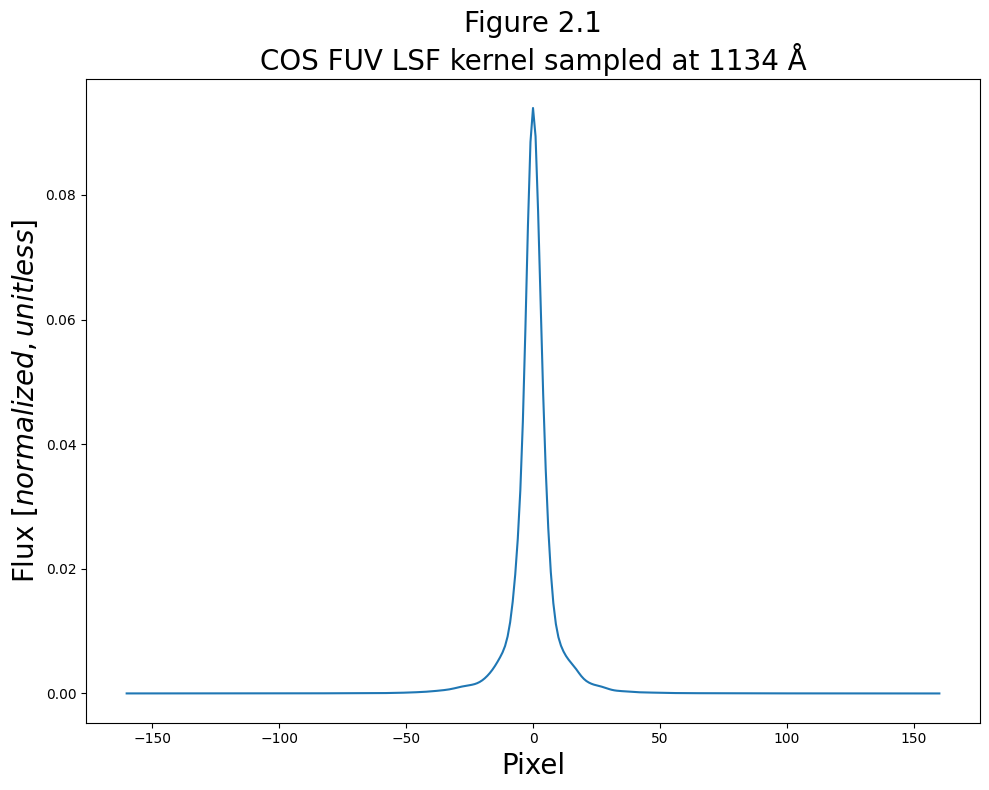

In [10]:
# Set up the figure
plt.figure(figsize=(10, 8))

# Fill the figure with a plot of the data
plt.plot(pix, lsf["1134"])

# Give figure the title and labels
plt.title("Figure 2.1\nCOS FUV LSF kernel sampled at 1134 Å",
          size=20)
plt.xlabel("Pixel",
           size=20)
plt.ylabel("Flux [$normalized,unitless$]",
           size=20)

# Format and save the figure
plt.tight_layout()

plt.savefig(str(plotsdir / "oneKernel.png"),
            bbox_inches="tight")

**We'll now make a more complex plot showing all of the lines contained in the LSF file, distributed in wavelength space.**

*Note* that while the centers of the lines are correctly mapped to the LSF wavelength at which they were sampled, their kernel width *in pixels* has only been roughly translated to a wavelength range in Å. In short, the x-axis is not strictly to-scale. This will be rectified by the remapping shown in Fig 3.1.

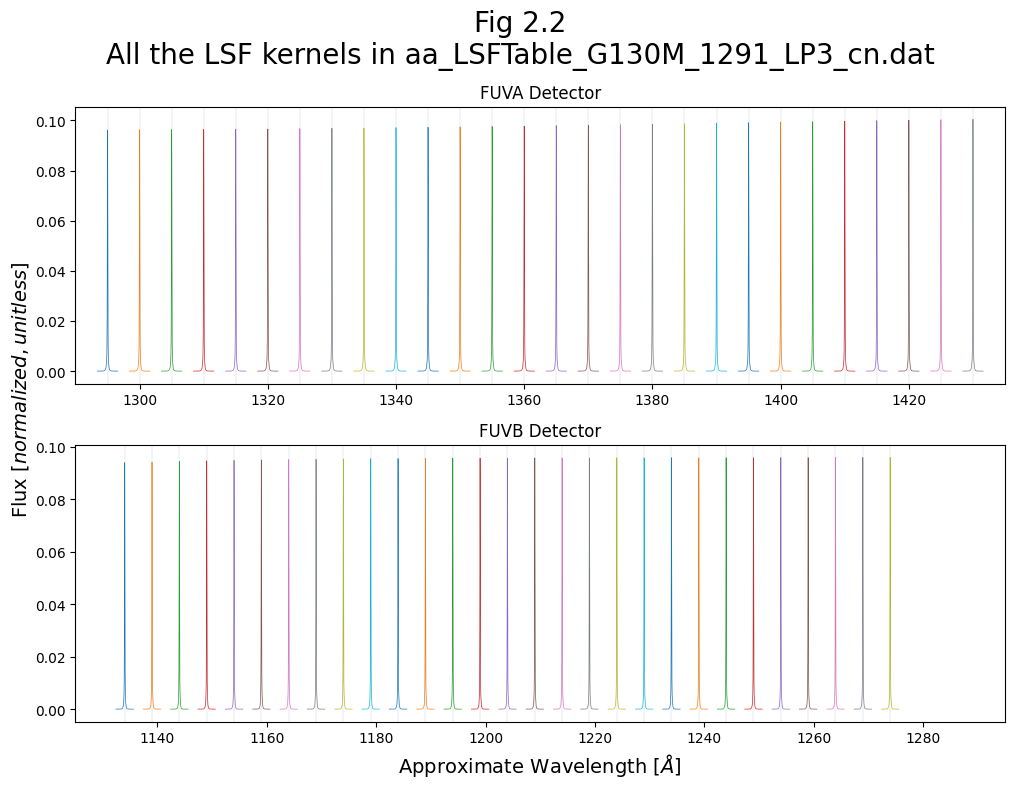

In [11]:
fig, (ax0, ax1) = plt.subplots(2, 1,
                               figsize=(10, 8),
                               dpi=100)

# Loop through the lsf kernels
for i, col in enumerate(lsf.colnames):
    # Central position
    line_wvln = int(col)
    # Actual shape
    contents = lsf[col].data

    # Split into the FUVB segment
    if line_wvln < 1291:
        # ROUGHLY convert pix to wvln
        xrange = 0.00997 * pix + line_wvln

        # Plot the kernel
        ax1.plot(xrange, contents,
                 linewidth=0.5)
        
        # Plot the LSF wvln as a faded line
        ax1.axvline(line_wvln,
                    linewidth=0.1)

    # Split into the FUVA segment
    elif line_wvln > 1291:
        # ROUGHLY convert pix to wvln
        xrange = 0.00997 * pix + line_wvln
        
        # Plot the kernel
        ax0.plot(xrange, contents,
                 linewidth=0.5)
        
        # Plot the LSF wvln as a faded line
        ax0.axvline(line_wvln,
                    linewidth=0.1)

# Format the figure
ax0.set_xlim(1290, 1435)
ax1.set_xlim(1125, 1295)

# Add labels, titles and text
fig.suptitle(f"Fig 2.2\nAll the LSF kernels in {LSF_file_name}",
             fontsize=20)
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")
ax1.set_xlabel(r"Approximate Wavelength [$\AA$]",
               size=14)

fig.text(s="Flux [$normalized,unitless$]",
         x=-0.01,
         y=0.35,
         rotation="vertical",
         size=14)

plt.tight_layout()

# Save the figure
plt.savefig(str(plotsdir / "allKernels.png"),
            bbox_inches="tight")

#### We will also demonstrate all of the above for a NUV dataset:

**First, downloading the NUV data and getting the relevant header parameters:**

In [12]:
# NUV: download the data
pl = Observations.get_product_list(
    Observations.query_criteria(obs_id="LBY606010")
)
# Search for file, generate data product list
download = Observations.download_products(
    # Filter and download searched files
    pl[pl["productSubGroupDescription"] == "X1DSUM"],
    download_dir=str(datadir),
)

# Give the program the path to your downloaded data
nuvFile = download["Local Path"][0]


# NUV: get relavent params:
# Select the primary header
nuvHeader0 = fits.getheader(nuvFile,
                            ext=0)

print(f"For the file {nuvFile}, the relevant parameters are: ")

# Make a dict to store what you find here
nuv_param_dict = {}

for hdrKeyword in [
    "DETECTOR",
    "OPT_ELEM",
    "LIFE_ADJ",
    "CENWAVE",
    "DISPTAB",
]:
    # For DISPTAB
    try:
        # Save the key/value pairs to the dictionary
        value = nuvHeader0[hdrKeyword].split("$")[1]
        # DISPTAB needs the split here
        nuv_param_dict[hdrKeyword] = value
    # For other params
    except (IndexError, AttributeError):
        # Save the key/value pairs to the dictionary
        value = nuvHeader0[hdrKeyword]
        nuv_param_dict[hdrKeyword] = value

    # Print the key/value pairs
    print(f"{hdrKeyword} = {value}")

INFO: Found cached file data/mastDownload/HST/lby606010/lby606010_x1dsum.fits with expected size 244800. [astroquery.query]
For the file data/mastDownload/HST/lby606010/lby606010_x1dsum.fits, the relevant parameters are: 
DETECTOR = NUV
OPT_ELEM = G185M
LIFE_ADJ = 1
CENWAVE = 1921
DISPTAB = 63p1559jl_disp.fits


**Downloading the disptab and LSF files:**

In [13]:
# NUV: Fetch disptab + LSF files
# We'll pass that fetch function the parameters we determined earlier
# This phrasing works because of the order in which we added the params to the dict
nuv_LSF_file_name, nuv_disptab_path = fetch_files(*list(nuv_param_dict.values()))

Downloaded LSF file to data/nuv_model_lsf.dat
Downloaded DISPTAB file to data/63p1559jl_disp.fits


**Read in the NUV LSF kernels and plot them:**

In [14]:
# Read in the NUV LSF kernels:
lsf_nuv, pix_nuv, colnames_nuv = read_lsf(str(datadir / nuv_LSF_file_name))

Detector used: nuv


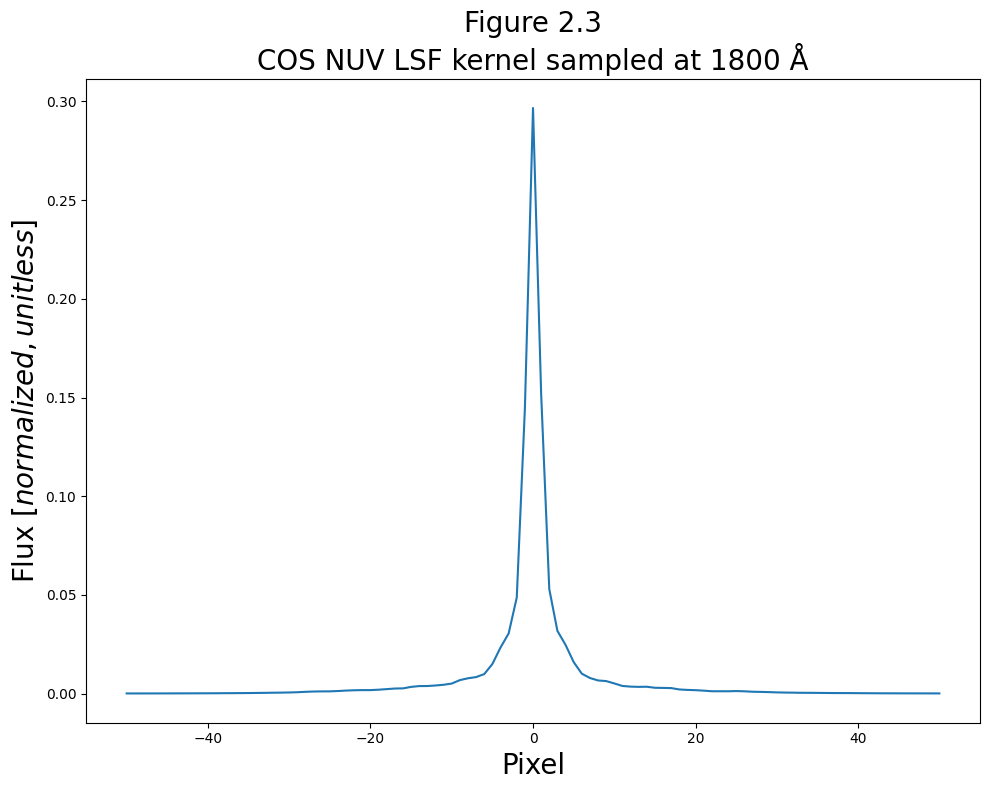

In [15]:
# Set up the figure
plt.figure(figsize=(10, 8))

# Fill the figure with a plot of the data
plt.plot(pix_nuv, lsf_nuv["1800"])

# Give fig the title and labels
plt.title("Figure 2.3\nCOS NUV LSF kernel sampled at 1800 Å",
          size=20)
plt.xlabel("Pixel",
           size=20)
plt.ylabel("Flux [$normalized,unitless$]",
           size=20)

# format and save the figure
plt.tight_layout()
plt.savefig(str(plotsdir / "oneKernel_nuv.png"),
            bbox_inches="tight")

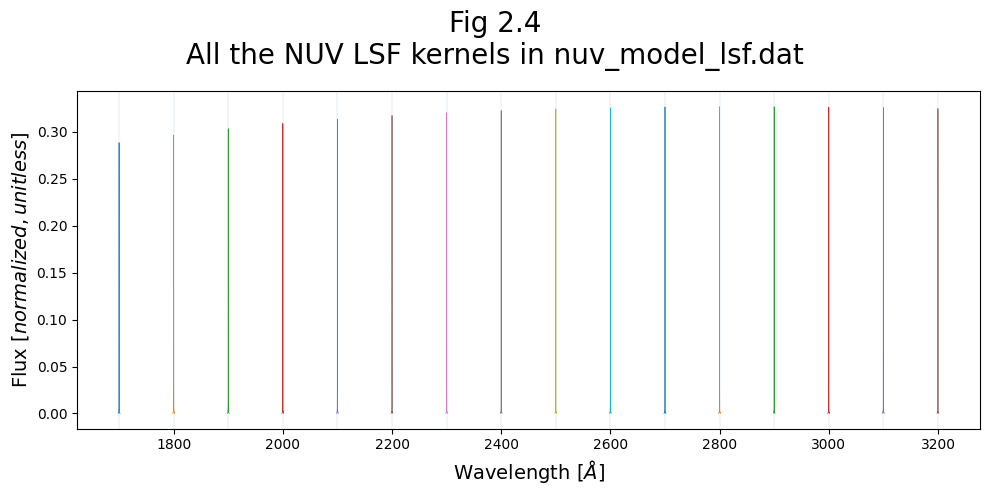

In [16]:
# Get the approximate NUV dispersion to convert pixel --> wavelength
nuv_dtab = Table.read(nuv_disptab_path)
approx_disp = nuv_dtab[
    np.where(
        (nuv_dtab["CENWAVE"] == 1921)
        & (nuv_dtab["SEGMENT"] == "NUVB")
        & (nuv_dtab["APERTURE"] == "PSA")
    )
]["COEFF"][0][1]

# Now plot:
fig, (ax0) = plt.subplots(1, 1,
                          figsize=(10, 5),
                          dpi=100)

# Loop through the lsf kernels:
for i, col in enumerate(lsf_nuv.colnames):
    # Central position
    line_wvln = int(col)  
    # Actual data on line shape
    contents = lsf_nuv[col].data

    # Roughly convert pix to wvln
    xrange = approx_disp * pix_nuv + line_wvln  
    # Plot the kernel
    ax0.plot(xrange, contents,
             linewidth=0.5)  
    # Plot the LSF wvln as a faded line
    ax0.axvline(line_wvln,
                linewidth=0.1)  

# Add labels, titles and text
fig.suptitle(f"Fig 2.4\nAll the NUV LSF kernels in {nuv_LSF_file_name}",
             fontsize=20)
ax0.set_xlabel(r"Wavelength [$\AA$]",
               size=14)
ax0.set_ylabel("Flux [$normalized,unitless$]",
               size=14)

# Format and save the figure
plt.tight_layout()

plt.savefig(str(plotsdir / "allKernels_nuv.png"),
            bbox_inches="tight")

<a id = convL></a>
## 3. Convolving an LSF

Now we come to the **central goal of the Notebook, convolving a spectrum with the COS LSF.** We'll begin by defining some functions we'll use for the convolution.

<a id = funcL></a>
### 3.1. Defining some functions for LSF convolution

We've already defined a function to read in the LSF file, but we'll need the main function to take a spectrum and convolve it with the LSF kernel. We'll call this function: `convolve_lsf`. This function will, in turn, call two short functions: `get_disp_params` and `redefine_lsf`.

<a id = fndispL></a>
#### 3.1.1. Getting the dispersion relationship parameters
First, we'll define a function, `get_disp_params`, to interpret the DISPTAB to find the dispersion relationship.
If provided with a range of pixel values, it will apply the dispersion relationship to those values and return the equivalent wavelength values as well as the dispersion coefficients.

In [17]:
def get_disp_params(disptab, cenwave, segment, x=[]):
    """
    Helper function to redefine_lsf(). Reads through a DISPTAB file and gives relevant
    dispersion relationship/wavelength solution over input pixels.

    Parameters:
    disptab (str): Path to your DISPTAB file.
    cenwave (str): Cenwave for calculation of dispersion relationship.
    segment (str): FUVA or FUVB?
    x (list): Range in pixels over which to calculate wvln with dispersion relationship (optional).
    
    Returns:
    disp_coeff (list): Coefficients of the relevant polynomial dispersion relationship
    wavelength (list; if applicable): Wavelengths corresponding to input x pixels 
    """
    with fits.open(disptab) as d:
        wh_disp = np.where(
            (d[1].data["cenwave"] == cenwave)
            & (d[1].data["segment"] == segment)
            & (d[1].data["aperture"] == "PSA")
        )[0]
        # 0 is needed as this returns nested list [[arr]]
        disp_coeff = d[1].data[wh_disp]["COEFF"][0]
    
    # If given a pixel range, build up a polynomial wvln solution pix -> λ
    if len(x):
        wavelength = np.polyval(p=disp_coeff[::-1], x=np.arange(16384))
        return disp_coeff, wavelength
    
    # If x is empty:
    else:
        return disp_coeff

<a id="fnredefL"></a>
#### 3.1.2. Redefining the LSF in terms of wavelength

Now, we'll define a function, `redefine_lsf`, to apply the dispersion relationship to the LSF kernels.
This effectively converts an LSF kernel from a function of pixel to a function of wavelength, making it compatible with a spectrum. 

In [18]:
def redefine_lsf(lsf_file, cenwave, disptab, detector="FUV"):
    """
    Helper function to convolve_lsf(). Converts the LSF kernels in the LSF file from a fn(pixel) -> fn(λ)
    which can then be used by convolve_lsf() and re-bins the kernels.

    Parameters:
    lsf_file (str): path to your LSF file
    cenwave (str): Cenwave for calculation of dispersion relationship
    disptab (str): path to your DISPTAB file
    detector (str): FUV or NUV?

    Returns:
    new_lsf (numpy.ndarray): Remapped LSF kernels.
    new_w (numpy.ndarray): New LSF kernel's LSF wavelengths.
    step (float): first order coefficient of the FUVA dispersion relationship; proxy for Δλ/Δpixel.
    """

    if detector == "FUV":
        xfull = np.arange(16384)

        # Read in the dispersion relationship here for the segments
        # FUVA is simple
        disp_coeff_a, wavelength_a = get_disp_params(disptab,
                                                     cenwave,
                                                     "FUVA",
                                                     x=xfull)
        
        # FUVB isn't taken for cenwave 1105, nor 800:
        if (cenwave != 1105) & (cenwave != 800):
            disp_coeff_b, wavelength_b = get_disp_params(disptab,
                                                         cenwave,
                                                         "FUVB",
                                                         x=xfull)
        elif cenwave == 1105:
            # 1105 doesn't have an FUVB so set it to something arbitrary and clearly not real:
            wavelength_b = [-99.0, 0.0]

        # Get the step size info from the FUVA 1st order dispersion coefficient
        step = disp_coeff_a[1]

        # Read in the lsf file
        lsf, pix, w = read_lsf(lsf_file)

        # Take median spacing between original LSF kernels
        deltaw = np.median(np.diff(w))

        # Resamples if the spacing of the original LSF wvlns is too narrow
        if (deltaw < len(pix) * step * 2):  
            # This is all a set up of the bins we want to use
            # The wvln difference between kernels of the new LSF should be about twice their width
            new_deltaw = round(len(pix) * step * 2.0)  

            # nw = Number of LSF wavelengths
            new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  

            # New version of lsf_wvlns
            new_w = min(w) + np.arange(new_nw) * new_deltaw  

            # Populating the lsf with the proper bins:
            # Empty 2-D array to populate
            new_lsf = np.zeros((len(pix), new_nw)) 

            for i, current_w in enumerate(new_w):
                # Find closest original LSF wavelength to new LSF wavelength
                dist = abs(current_w - w)  
                lsf_index = np.argmin(dist)
                # Column name corresponding to closest orig LSF wvln
                orig_lsf_wvln_key = lsf.keys()[lsf_index]  
                # Assign new LSF wvln the kernel of the closest original lsf wvln
                new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  

        else:
            new_lsf = lsf
            new_w = w

        return new_lsf, new_w, step

    elif detector == "NUV":
        xfull = np.arange(1024)

        # Read in the dispersion relationship here for the segments
        disp_coeff_a, wavelength_a = get_disp_params(disptab,
                                                     cenwave,
                                                     "NUVA",
                                                     x=xfull)
        
        disp_coeff_b, wavelength_b = get_disp_params(disptab,
                                                     cenwave,
                                                     "NUVB",
                                                     x=xfull)
        
        disp_coeff_c, wavelength_c = get_disp_params(disptab,
                                                     cenwave,
                                                     "NUVC",
                                                     x=xfull)

        # Get the step size info from the NUVB 1st order dispersion coefficient
        step = disp_coeff_b[1]

        # Read in the lsf file
        lsf, pix, w = read_lsf(lsf_file)

        # Take median spacing between original LSF kernels
        deltaw = np.median(np.diff(w))

        # This section is a set up of the new bins we want to use:
        # The wvln difference between kernels of the new LSF should be about twice their width
        new_deltaw = round(len(pix) * step * 2.0) 

        # nw = Number of LSF wavelengths
        new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  

        # New version of lsf_wvlns
        new_w = min(w) + np.arange(new_nw) * new_deltaw  

        # Populating the lsf with the proper bins:
        # Empty 2-D array to populate
        new_lsf = np.zeros((len(pix), new_nw))  

        for i, current_w in enumerate(new_w):
            # Find closest original LSF wavelength to new LSF wavelength
            dist = abs(current_w - w)  
            lsf_index = np.argmin(dist)

            # Column name corresponding to closest orig LSF wvln
            orig_lsf_wvln_key = lsf.keys()[lsf_index]  
            
            # Assign new LSF wvln the kernel of the closest original lsf wvln
            new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  
            
        return new_lsf, new_w, step

**Let's make a version of the Fig. 2.2 with these newly remapped LSF kernels:**

Detector used: fuv


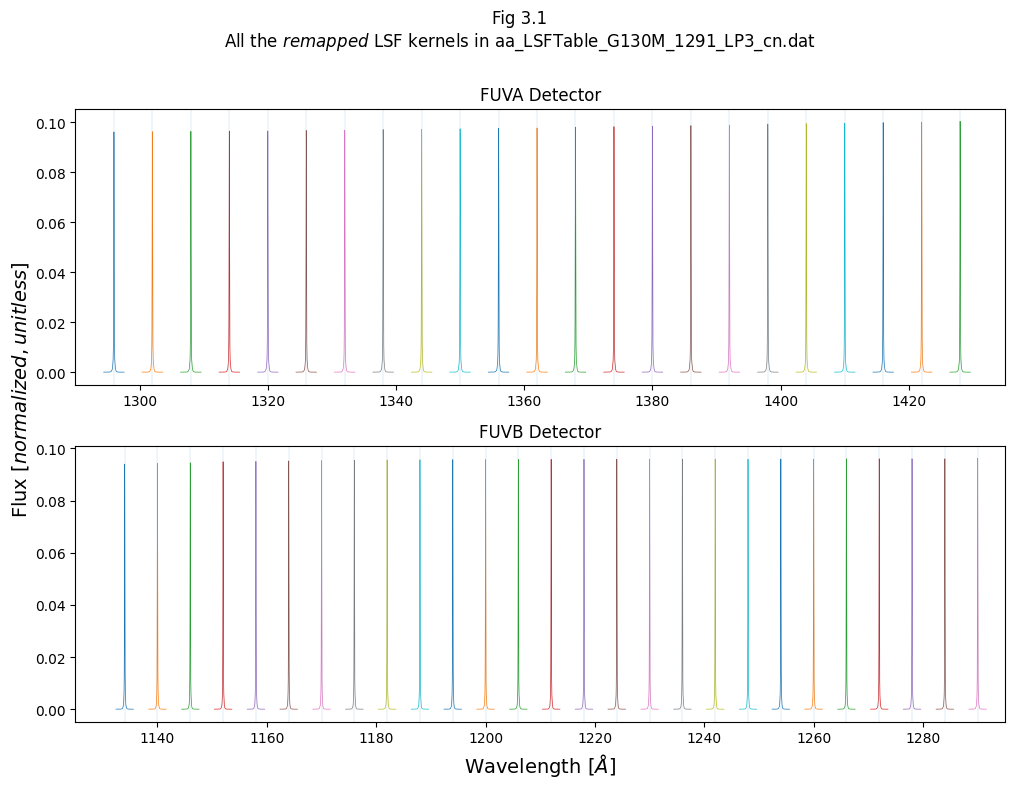

In [19]:
# Generate the redefined lsf for the plot
new_lsf, new_w, step = redefine_lsf(
    str(datadir / LSF_file_name),
    param_dict["CENWAVE"],
    str(datadir / param_dict["DISPTAB"]),
)

fig, (ax0, ax1) = plt.subplots(2, 1,
                               figsize=(10, 8),
                               dpi=100)

# Loop through the new remapped lsf kernels
for i, col in enumerate(new_w):
    # Central position
    line_wvln = int(col)
    # Actual shape  
    contents = new_lsf[:, i]  

    # Split into the FUVB segment
    if line_wvln < 1291:  
        # ROUGHLY convert pix to wvln
        xrange = new_w[i] + pix * step  
        
        # Plot the kernel
        ax1.plot(xrange, contents,
                 linewidth=0.5)  
        
        # Plot the LSF wvln as a faded line
        ax1.axvline(line_wvln,
                    linewidth=0.1) 
         
    # Split into the FUVA segment
    elif line_wvln > 1291:  
        # ROUGHLY convert pix to wvln
        xrange = new_w[i] + pix * step  
        # Plot the kernel
        ax0.plot(xrange, contents,
                 linewidth=0.5)  
        # Plot the LSF wvln as a faded line
        ax0.axvline(line_wvln,
                    linewidth=0.1)  

# Add labels, titles and text
fig.suptitle(f"Fig 3.1\nAll the $remapped$ LSF kernels in {LSF_file_name}\n")
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")

ax0.set_xlim(1290, 1435)
ax1.set_xlim(1125, 1295)

ax1.set_xlabel(r"Wavelength [$\AA$]",
               size=14)
fig.text(s="Flux [$normalized,unitless$]",
         x=-0.01,
         y=0.35,
         rotation="vertical",
         size=14)

# format and save the figure
plt.tight_layout()

plt.savefig(str(plotsdir / "allKernels_new.png"),
            bbox_inches="tight")

<a id = fnconvL></a>
#### 3.1.3. Applying the convolution

Finally, we'll define the main function, `convolve_lsf`, to convolve the template spectrum with the redefined LSF:



In [20]:
def convolve_lsf(wavelength, spec, cenwave, lsf_file, disptab, detector="FUV"):
    """
    Main function; Convolves an input spectrum - i.e. template or STIS spectrum - with the COS LSF.

    Parameters:
    wavelength (list or array): Wavelengths of the spectrum to convolve.
    spec (list or array): Fluxes or intensities of the spectrum to convolve.
    cenwave (str): Cenwave for calculation of dispersion relationship
    lsf_file (str): Path to your LSF file
    disptab (str): Path to your DISPTAB file
    detector (str) : Assumes an FUV detector, but you may specify 'NUV'.

    Returns:
    wave_cos (numpy.ndarray): Wavelengths of convolved spectrum.!Different length from input wvln
    final_spec (numpy.ndarray): New LSF kernel's LSF wavelengths.!Different length from input spec
    """
    # First calls redefine to get right format of LSF kernels
    new_lsf, new_w, step = redefine_lsf(lsf_file,
                                        cenwave,
                                        disptab,
                                        detector=detector)

    # Sets up new wavelength scale used in the convolution
    nstep = round((max(wavelength) - min(wavelength)) / step) - 1
    wave_cos = min(wavelength) + np.arange(nstep) * step

    # Resampling onto the input spectrum's wavelength scale:
    # Builds up interpolated function from input spectrum
    interp_func = interp1d(wavelength, spec)  

    # Builds interpolated initial spectrum at COS' wavelength scale for convolution
    spec_cos = interp_func(wave_cos)  

    # Initializes final spectrum to the interpolated input spectrum
    final_spec = interp_func(wave_cos)  

    # Loop through the redefined LSF kernels:
    for i, w in enumerate(new_w):  
        # First need to find the boundaries of each kernel's "jurisdiction": where it applies
        # The first and last elements need to be treated separately

        # First kernel:
        if i == 0:  
            diff_wave_left = 500
            diff_wave_right = (new_w[i + 1] - w) / 2.0

        # Last kernel
        elif i == len(new_w) - 1:  
            diff_wave_right = 500
            diff_wave_left = (w - new_w[i - 1]) / 2.0

        # All other kernels
        else:  
            diff_wave_left = (w - new_w[i - 1]) / 2.0
            diff_wave_right = (new_w[i + 1] - w) / 2.0

        # Splitting up the spectrum into slices around the redefined LSF kernel wvlns
        # Will apply the kernel corresponding to that chunk to that region of the spectrum - its "jurisdiction"
        chunk = np.where(
            (wave_cos < w + diff_wave_right) & (wave_cos >= w - diff_wave_left)
        )[0]
        if len(chunk) == 0:
            # Off the edge, go to the next chunk
            continue

        # Selects the current kernel
        current_lsf = new_lsf[:, i]  

        if len(chunk) >= len(
            current_lsf
        ):  # Makes sure that the kernel is smaller than the chunk
            final_spec[chunk] = convolve(
                spec_cos[chunk],
                # Applies the actual convolution
                current_lsf,  
                boundary="extend",
                normalize_kernel=True,
            )

    # Remember, not the same length as input spectrum data!
    return wave_cos, final_spec  

<a id = picketL></a>
### 3.2. Convolving simple line profiles

Let's demonstrate the convolution with a quick initial plot.

The cell below first creates a simple synthetic spectrum (with a wavelength range from 1147-1153Å and a Voigt profile emission line at 1150Å), then convolves it with the COS LSF. The next cell then plots the two spectra together.

In [21]:
# Generate data:
# Define a model spectral line with a Voigt profile
voigt_shape = functional_models.Voigt1D(x_0=1150,
                                        amplitude_L=1,
                                        fwhm_G=0.05,
                                        fwhm_L=0.05)

# Make a simple spectrum with just that line at 1150 Å:
# Generate x data - Minimum size of Δ6Å for the kernel to apply here.
wvln_in = np.linspace(1147, 1153,
                      int(1e5))  

# Generate the y data
spec_in = voigt_shape(wvln_in)  

# Normalize the y data to a max of 1
spec_in /= max(spec_in) 

# Run the convolution:
wvln_out, spec_out = convolve_lsf(
    wvln_in,
    spec_in,
    1291,
    str(datadir / LSF_file_name),
    str(datadir / param_dict["DISPTAB"]))

Detector used: fuv


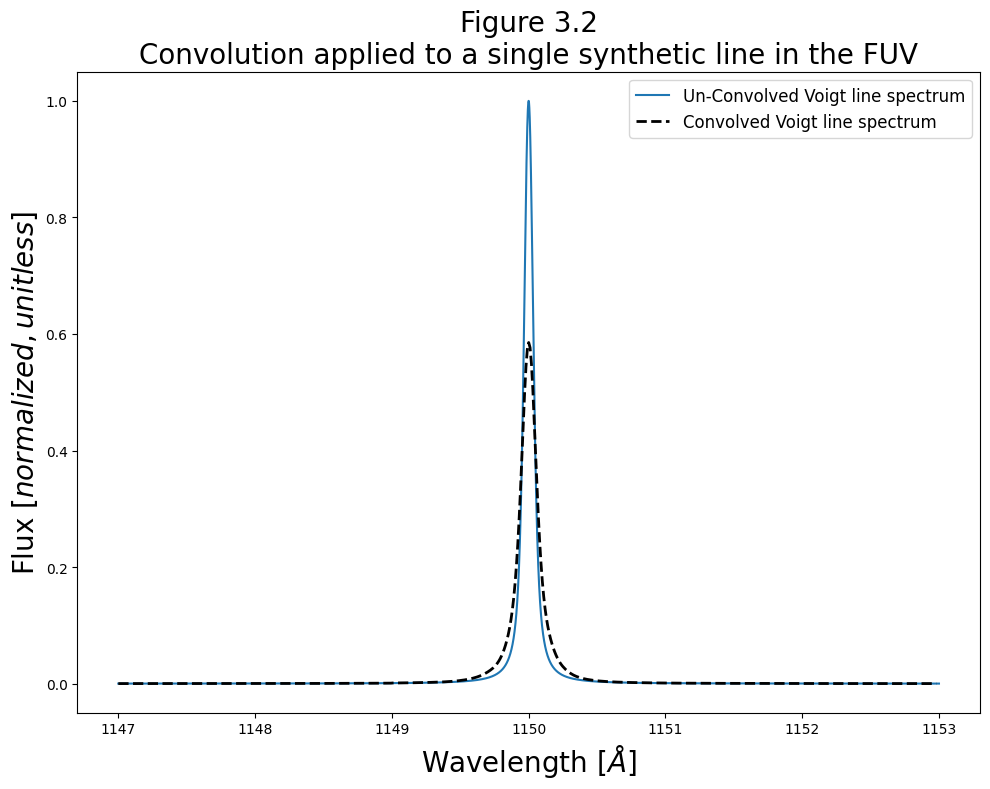

In [22]:
# Make a plot from the data generated above:
plt.figure(figsize=(10, 8))

# Plot the two spectra
plt.plot(wvln_in, spec_in,
         label="Un-Convolved Voigt line spectrum")

plt.plot(
    wvln_out, spec_out,
    linestyle="--",
    linewidth=2,
    c="k",
    label="Convolved Voigt line spectrum",)

# Format and give fig the title and labels
plt.title("Figure 3.2\nConvolution applied to a single synthetic line in the FUV",
          size=20)
plt.xlabel(r"Wavelength [$\AA$]",
           size=20)
plt.ylabel("Flux [$normalized,unitless$]",
           size=20)

# Add a legend
plt.legend(fontsize=12,
           loc="upper right")

# Save the figure
plt.tight_layout()

plt.savefig(str(plotsdir / "applyConv1.png"),
            bbox_inches="tight")

As shown above, the LSF pushes power from the line's peak into the wings of the line profile.

And, as we confirm below, the total flux has not changed, but has just been spread out:

In [23]:
integral1 = np.trapz(x=wvln_in, y=spec_in)
integral2 = np.trapz(x=wvln_out, y=spec_out)

print(f"The integrated fluxes are within {100 * (integral1-integral2)/integral2:.2f} % of eachother")

The integrated fluxes are within 0.06 % of eachother


/tmp/ipykernel_2863/3203720875.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral1 = np.trapz(x=wvln_in, y=spec_in)
/tmp/ipykernel_2863/3203720875.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral2 = np.trapz(x=wvln_out, y=spec_out)


**We can now examine how the convolution differs across the spectrum.**
We do this by creating a ["picket fence"/"frequency comb"](https://en.wikipedia.org/wiki/Frequency_comb)-like spectrum of evenly-spaced, identical, normalized Voigt profiles. Each of these lines is normalized to a maximum of 1. 

We'll make our synthetic spectrum slightly more realistic by converting from emission lines to absorption lines on a flat spectrum. To do this, we define a simple function, `emit2abs()`, which defines a flat continuum of 1, then multiplies this continuum by $e^{-emission\ spectrum}$

We then use `convolve_lsf` to convolve each of these synthetic spectral lines with the LSF kernel under whose "jurisdiction" they fall. For each line, we plot *pre-* and *post-* convolution spectrum in the 8 smaller panels. In the bottom, larger panel, we also plot the entire spectrum of all the lines.

In [24]:
def emit2abs(emitspec, continuum=-1):
    """
    Takes an emission spectrum and "reverses" it, that is it:
    Makes a default flat continuum of 1 and subtracts exp(line)
    
    Inputs:
    emitspec (1D arraylike): the emission spectrum
    continuum (array or -1) : if -1, default of continuum of 1, \
        otherwise must be same length as emitspec
    """
    if type(continuum) is int:
        if continuum == -1:
            continuum = np.ones(len(emitspec))
            
    abs_spec = continuum * np.exp(-1.0 * emitspec)

    return abs_spec

Detector used: fuv


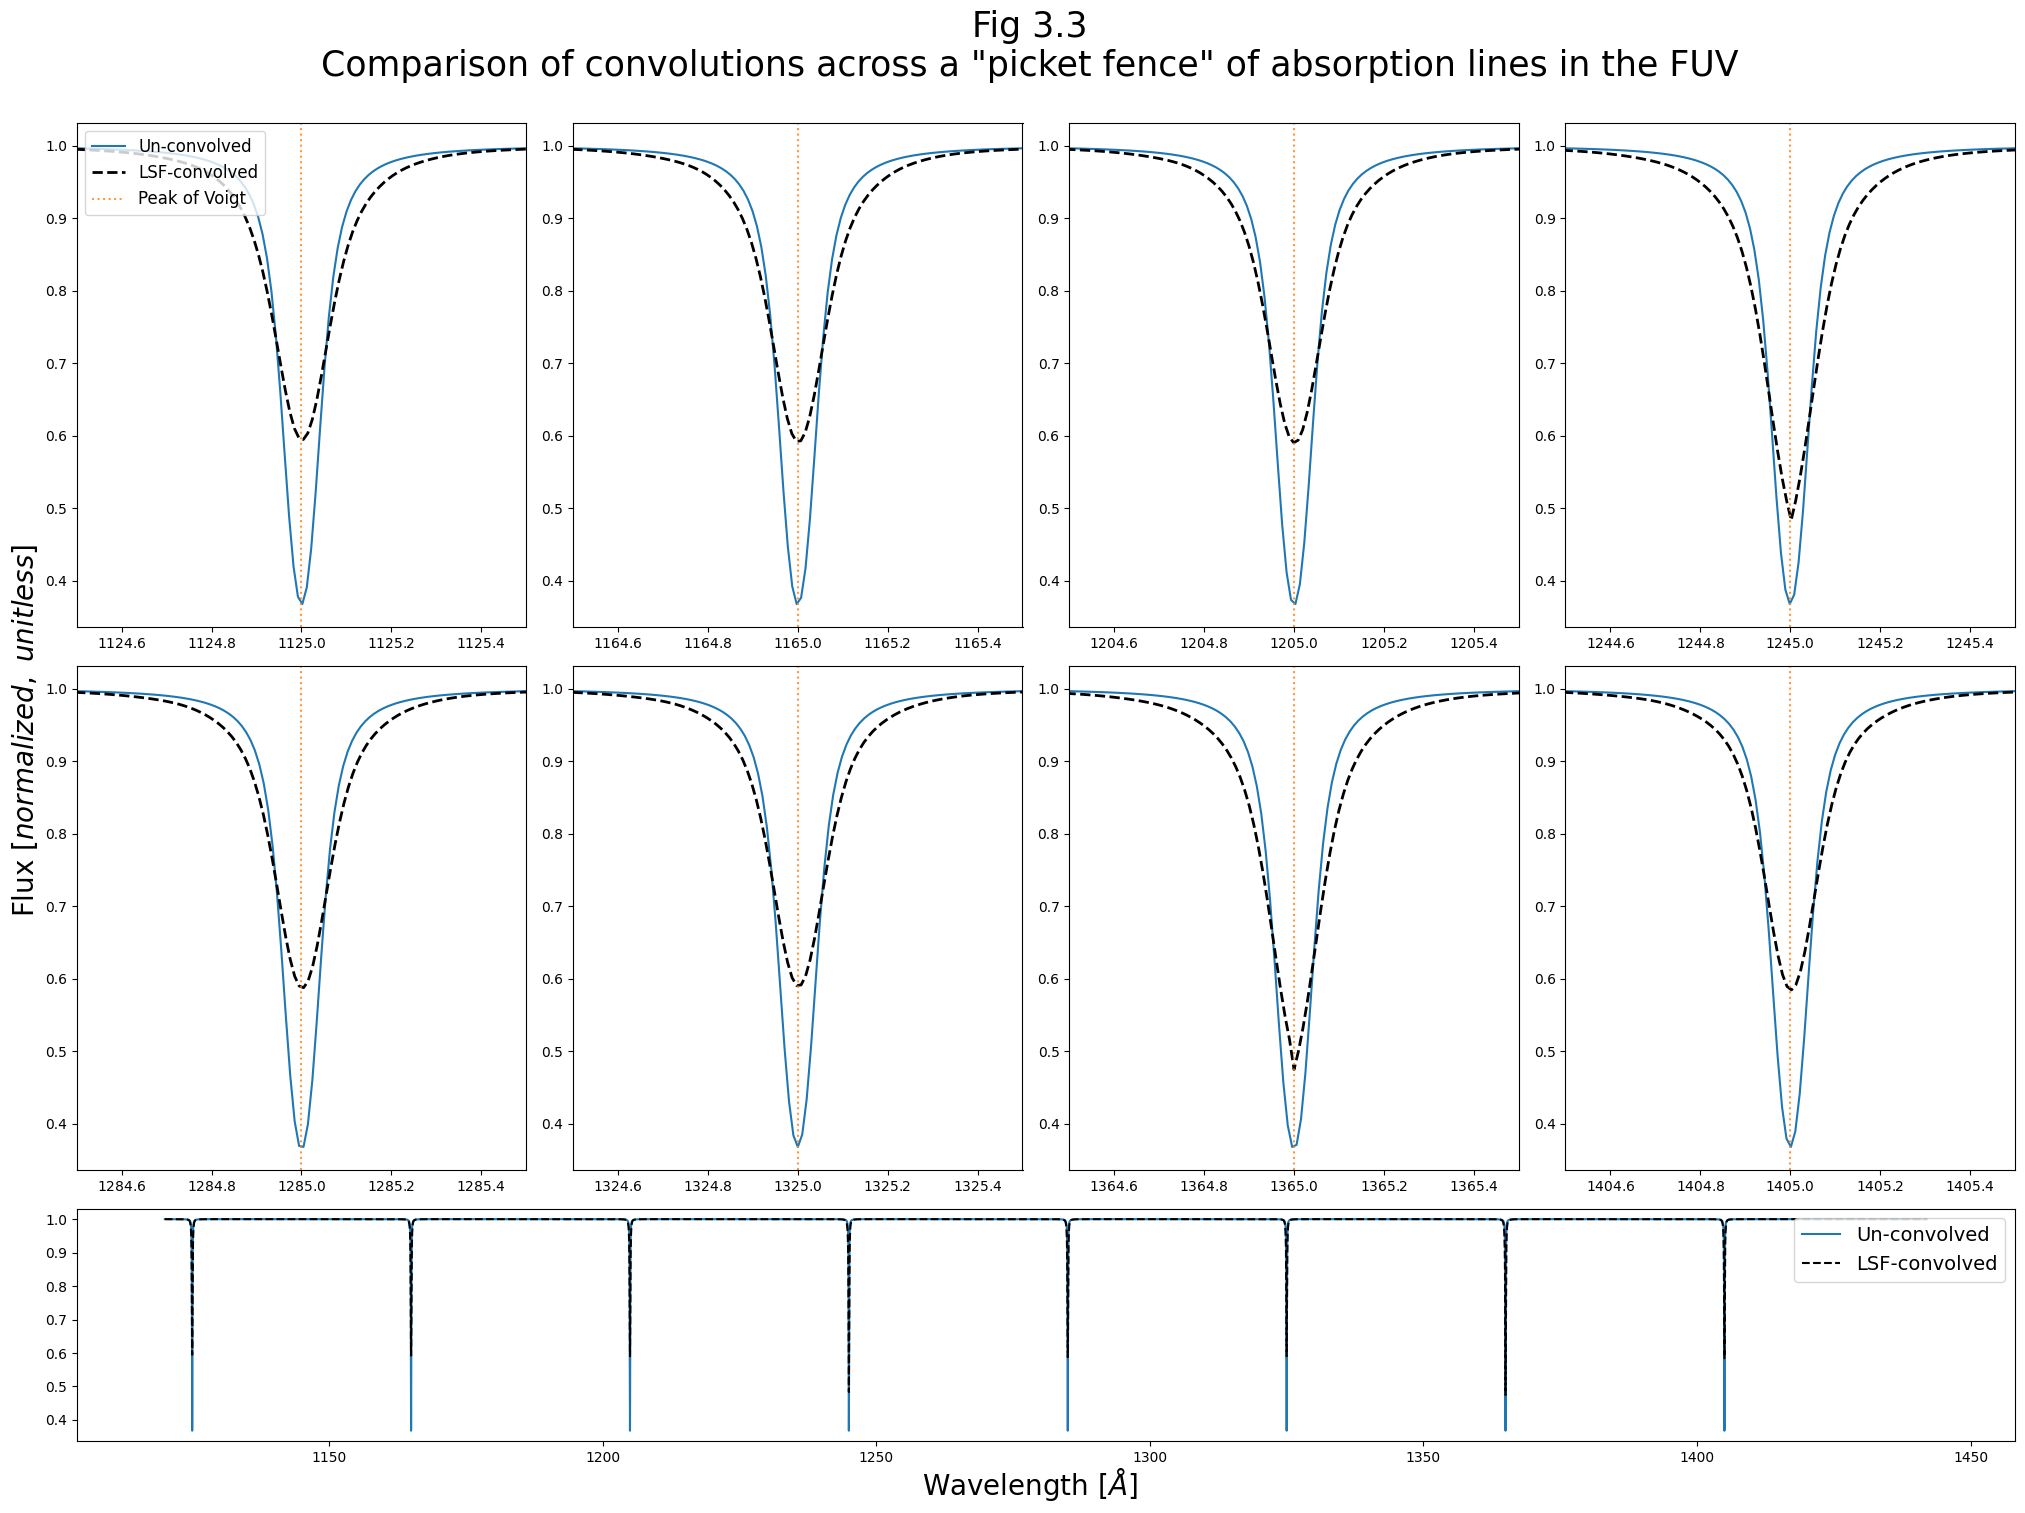

In [25]:
# Build up a synthetic wavelength range comparable to a real COS spectrum
wvln = np.linspace(1120, 1442, 16384 * 2)  

# Initialize the spectrum to continuum of zero, we'll build it up with a series of Voigt profiles
flux = np.zeros(wvln.shape)
# A copy of flux that we'll add each new line's flux to, in turn
combo_flux = flux  

# Set up figure
fig = plt.figure(figsize=(20, 15))

# Using gridspec to control panel sizes and locations
gs = fig.add_gridspec(nrows=10, ncols=4)  

# Loop through the input spectrum's wavelength range and place a synthetic Voigt line every 40 Å
for i, discrete_wvln in enumerate(np.arange(int(min(wvln) + 5), max(wvln) - 5, 40)):
    voigt_shape = functional_models.Voigt1D(
        # Center a Voigt profile there
        x_0=discrete_wvln,  
        amplitude_L=1,
        fwhm_G=0.05,
        fwhm_L=0.05)
    
    # Evaluate flux from that Voigt profile function
    flux = voigt_shape(wvln) 

    # Normalize that line's flux
    flux /= max(flux)  

    # Add each line's flux to total summed flux
    combo_flux = combo_flux + flux  

# "Reverse" emission spectrum to absorption spectrum
combo_flux = emit2abs(combo_flux)

# Apply the convolution to the combined (many-line) synthetic spectrum to create an lsf_convolved wvln and flux
lwvln, lsf_combo_flux = convolve_lsf(
    wvln,
    combo_flux,
    1291,
    str(datadir / LSF_file_name),
    str(datadir / param_dict["DISPTAB"]))

# Make the plots

# Loop through again to build up the plots
# This will make 8 subplots
for i, discrete_wvln in enumerate(
    np.arange(int(min(wvln) + 5), max(wvln) - 5, 40)
):  
    # Build the small subplots for each line:
    # Add a plot at the correct position on the grid
    ax = fig.add_subplot(
        gs[4 * int(i / 4):4 * int(i / 4) + 4, i % 4:(i) % 4 + 1])  
    
    # First plot the original, unconvolved line at each position
    ax.plot(
        wvln, combo_flux,
        label="Un-convolved")
      
    # Now plot the convolved line
    ax.plot(lwvln, lsf_combo_flux,
            c="k",
            linestyle="--",
            linewidth=2,
            label="LSF-convolved")  

    # Now add the peak wvln
    ax.axvline(discrete_wvln,
               c="C1",
               linestyle="dotted",
               alpha=0.8,
               label="Peak of Voigt")  

    # Some formatting
    ax.set_xlim(discrete_wvln - 0.5, discrete_wvln + 0.5)

    ax.ticklabel_format(axis="x",
                        style="plain",
                        useOffset=True,
                        useMathText=True)
    
    # Add a legend to the first subplot
    if i == 0:  
        ax.legend(fontsize=12,
                  loc="upper left")

# Build up lower plot of all the lines:
low_ax = fig.add_subplot(gs[8:, :])

low_ax.plot(wvln, combo_flux,
            label="Un-convolved")

low_ax.plot(lwvln, lsf_combo_flux,
            c="k",
            linestyle="--",
            label="LSF-convolved")

low_ax.legend(fontsize=14,
              loc="upper right")

fig.suptitle(
    'Fig 3.3\nComparison of convolutions across a "picket fence" of absorption lines in the FUV\n',
    size=25)
fig.text(0.5, -0.01, r"Wavelength [$\AA$]",
         ha="center",
         fontsize=20)
fig.text(-0.01, 0.5,
         r"Flux [$normalized,\ unitless$]",
         va="center",
         rotation="vertical",
         fontsize=20,)

plt.tight_layout()

plt.savefig(str(plotsdir / "applyConv_picketFence.png"),
            bbox_inches="tight",
            dpi=200)

**The figure above demonstrates the way in which the LSF changes significantly throughout the wavelength range of a spectrum.**

It can be difficult to distinguish the LSFs plotted on their own; however, the results of their convolution with a synthetic line shows some are more sharply peaked, or contain more flux in the wings, etc.

**We'll finish this section with a brief example of convolving a line *in the NUV* with the relevant LSF:**

Detector used: nuv
The integrated fluxes are within 0.12 % of eachother


/tmp/ipykernel_2863/2282636597.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral1 = np.trapz(x=wvln_in, y=spec_in)
/tmp/ipykernel_2863/2282636597.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral2 = np.trapz(x=wvln_out, y=spec_out)


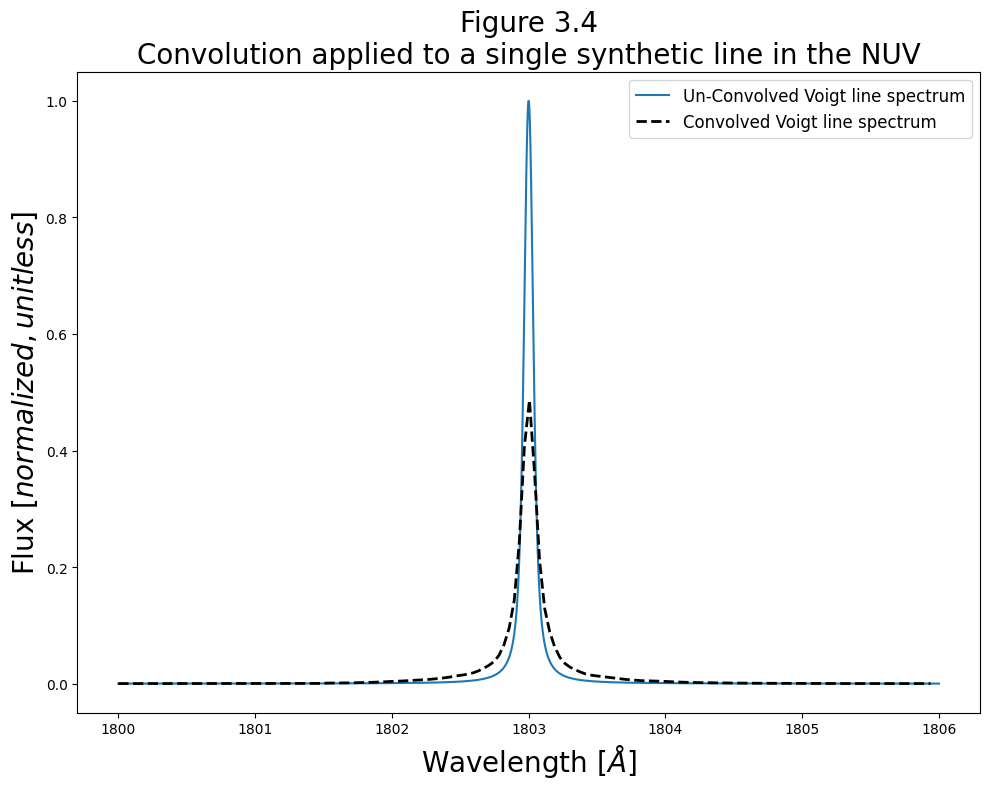

In [26]:
# Generate data:
# Define a model spectral line with a Voigt profile
voigt_shape = functional_models.Voigt1D(x_0=1803,
                                        amplitude_L=1,
                                        fwhm_G=0.05,
                                        fwhm_L=0.05)

# Make a simple spectrum with just that line at 1150 Å:
# Generate x data - Minimum size of Δ6Å for the kernel to apply here.
wvln_in = np.linspace(1800, 1806,
                      int(1e4))

# Generate the y data
spec_in = voigt_shape(wvln_in)  

# Normalize the y data to a max of 1
spec_in /= max(spec_in)

# Run the convolution:
wvln_out, spec_out = convolve_lsf(wavelength=wvln_in,
                                  spec=spec_in,
                                  cenwave=1786,
                                  lsf_file=str(datadir / nuv_LSF_file_name),
                                  disptab=nuv_disptab_path,
                                  detector="NUV")

# Make a plot from that data:
# Set up figure
plt.figure(figsize=(10, 8))

# Plot the two spectra
plt.plot(wvln_in, spec_in,
         label="Un-Convolved Voigt line spectrum")

plt.plot(wvln_out, spec_out,
         linestyle="--",
         linewidth=2,
         c="k",
         label="Convolved Voigt line spectrum")

# Add a legend
plt.legend(fontsize=12,
           loc="upper right")

# Give fig the title and labels
plt.title("Figure 3.4\nConvolution applied to a single synthetic line in the NUV",
          size=20)
plt.xlabel(r"Wavelength [$\AA$]",
           size=20)
plt.ylabel("Flux [$normalized,unitless$]",
           size=20)

# Format and save the figure
plt.tight_layout()

plt.savefig(str(plotsdir / "applyConv_nuv1.png"),
            bbox_inches="tight")

# Give the user a heads-up that the integrated fluxes should agree:
integral1 = np.trapz(x=wvln_in, y=spec_in)
integral2 = np.trapz(x=wvln_out, y=spec_out)

print(f"The integrated fluxes are within {100 * (integral1-integral2)/integral2:.2f} % of eachother")

**And we'll create an *NUV* equivalent of Fig. 3.3:**

Detector used: nuv


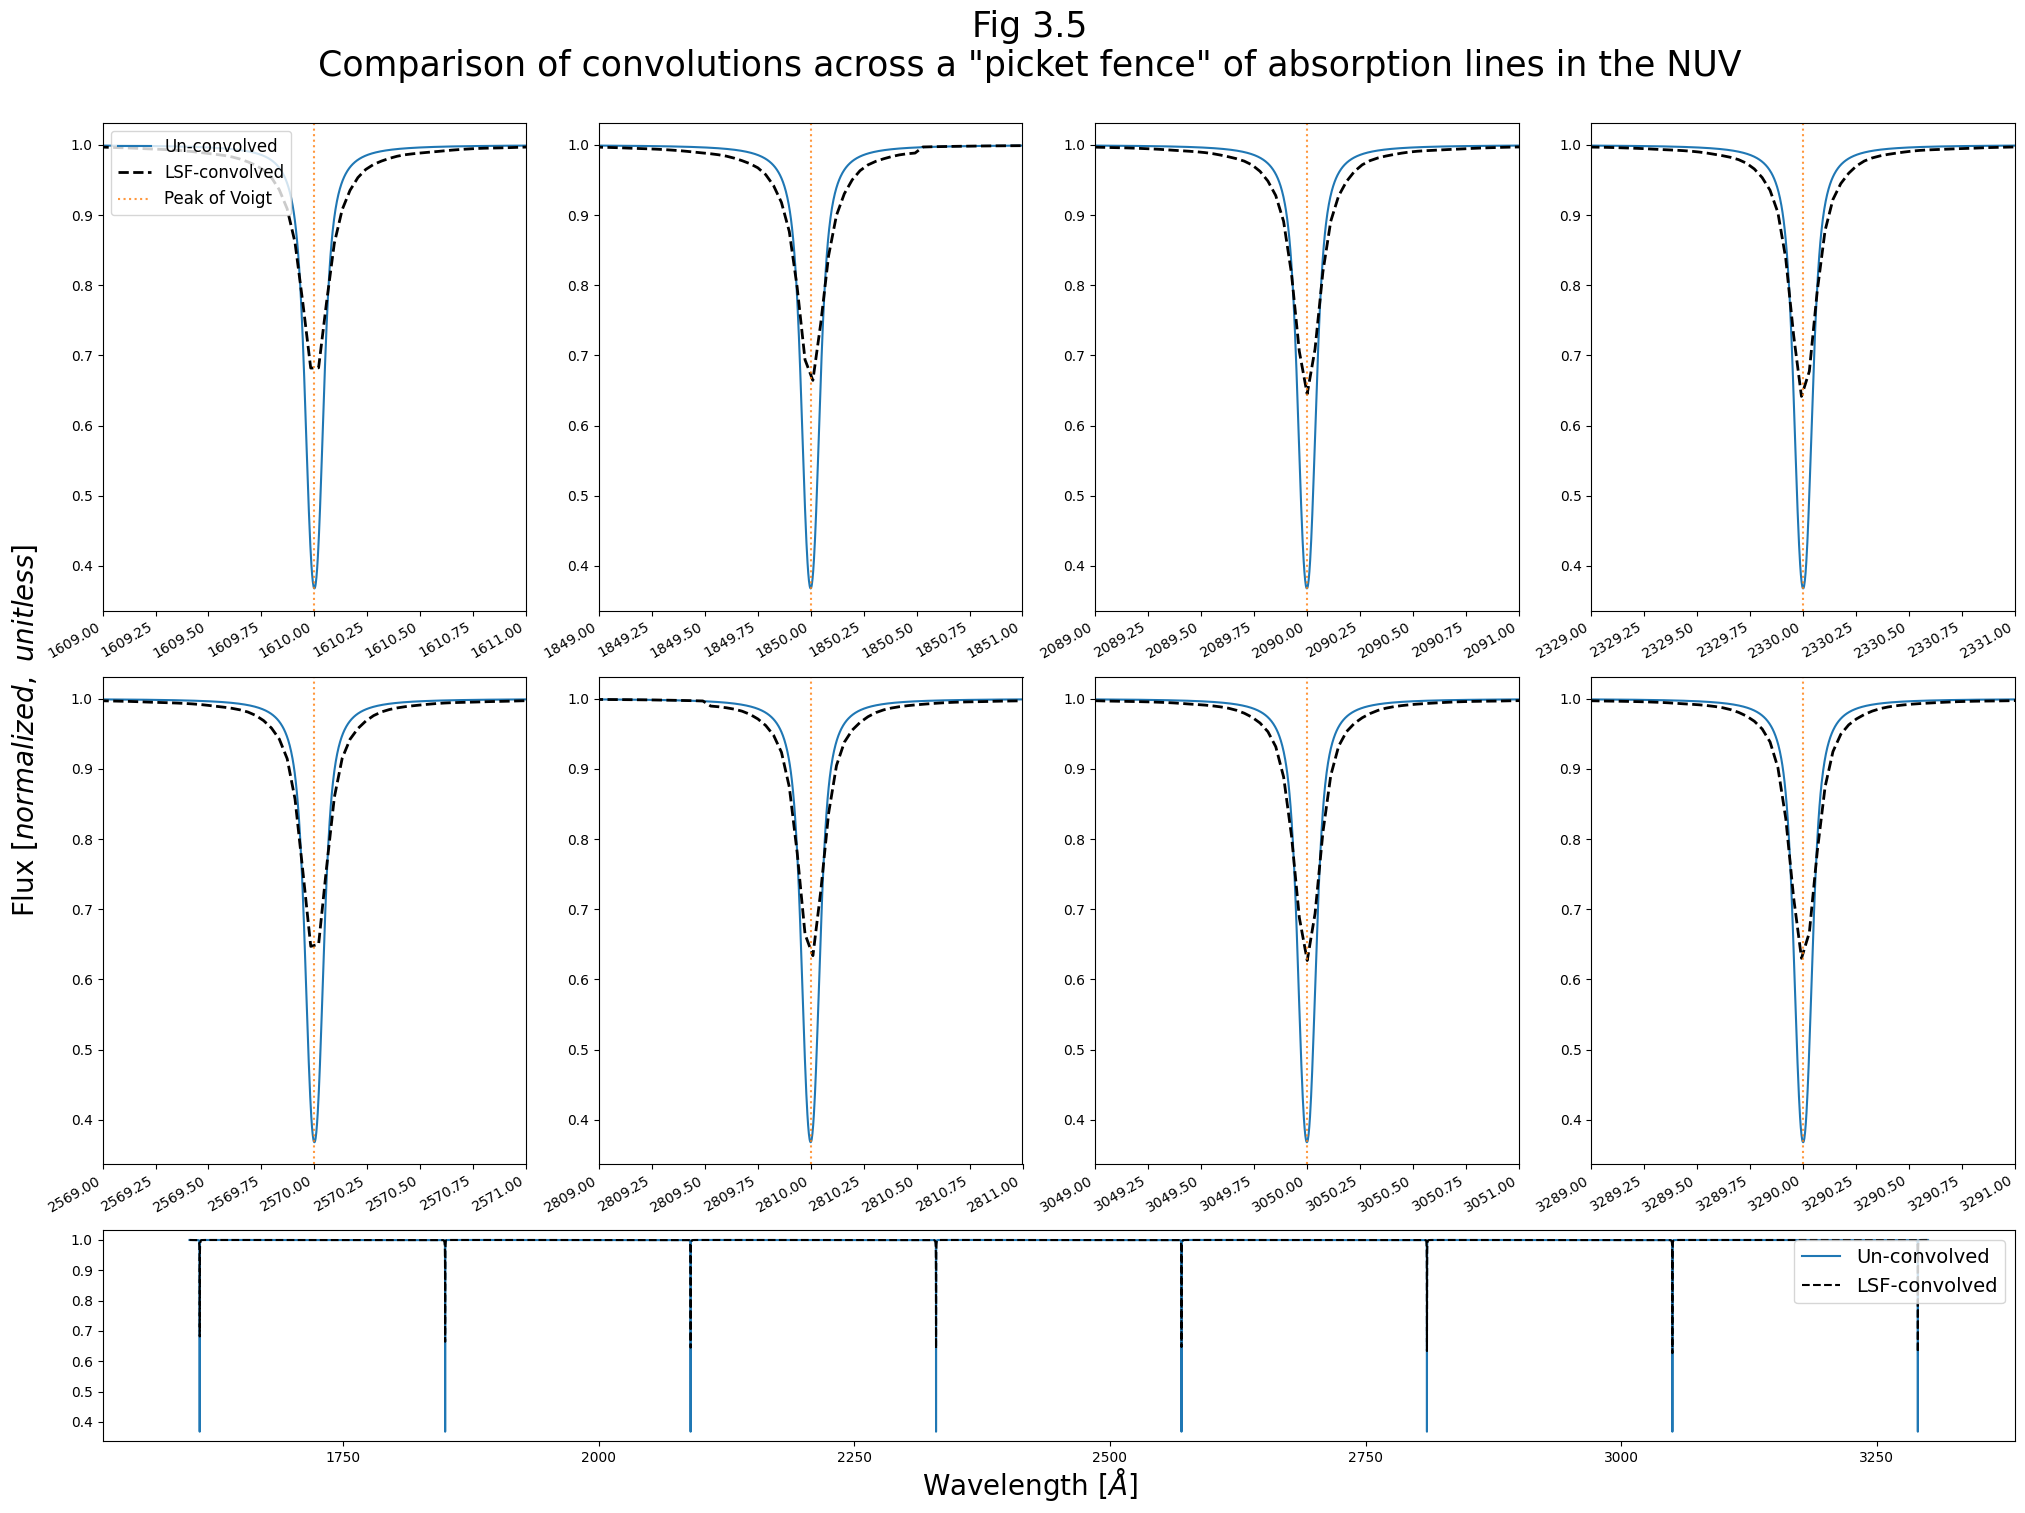

In [27]:
# Set up the DATA:
# Build up a synthetic wavelength range comparable to a real COS spectrum
wvln = np.linspace(1600, 3300,
                   int(1e6))

# Initialize the spectrum to zero, we'll build it up with a series of Voigt profiles
flux = np.zeros(wvln.shape)

# A copy of flux that we'll add each new line's flux to, in turn
combo_flux = flux

# Set up figure
fig = plt.figure(figsize=(20, 15))
# Using gridspec to let us control panel sizes and locations
gs = fig.add_gridspec(nrows=10, ncols=4)

# Loop through the input spectrum's wavelength range and place a synthetic Voigt line every 40 Å
for i, discrete_wvln in enumerate(np.arange(int(min(wvln) + 10), max(wvln) - 5, 240)):
    # Center a Voigt profile there
    voigt_shape = functional_models.Voigt1D(x_0=discrete_wvln,
                                            amplitude_L=1,
                                            fwhm_G=0.05,
                                            fwhm_L=0.05)
    
    # Evaluate flux from that Voigt profile function
    flux = voigt_shape(wvln)
    # Normalize that line's flux
    flux /= max(flux)
    # Add each line's flux to total summed flux
    combo_flux = combo_flux + flux

# Reverse emit -> abs spectrum
combo_flux = emit2abs(combo_flux)

# Apply the convolution to the combined (many-line) synthetic spectrum to create an lsf_convolved wvln and flux
lwvln, lsf_combo_flux = convolve_lsf(wvln,
                                     combo_flux,
                                     1786.0,
                                     lsf_file=str(datadir / nuv_LSF_file_name),
                                     disptab=nuv_disptab_path,
                                     detector="NUV")

# Make the plots:
# Loop through again to build up the 8 plots
for i, discrete_wvln in enumerate(
    np.arange(int(min(wvln) + 10), max(wvln) - 5, 240)
):
    # Build the small subplots for each line:
    # Add a plot at the right position on the grid
    ax = fig.add_subplot(gs[4 * int(i / 4):4 * int(i / 4) + 4, i % 4:(i) % 4 + 1])

    # First plot the original, unconvolved line at each position
    ax.plot(wvln, combo_flux, label="Un-convolved")

    # Now plot the convolved line
    ax.plot(lwvln, lsf_combo_flux,
            c="k",
            linestyle="--",
            linewidth=2,
            label="LSF-convolved")
    
    # Now add the peak wvln
    ax.axvline(discrete_wvln,
               c="C1",
               linestyle="dotted",
               alpha=0.8,
               label="Peak of Voigt")
    
    # Apply some formatting
    ax.set_xlim(discrete_wvln - 1.0, discrete_wvln + 1.0)

    ax.ticklabel_format(axis="x",
                        style="plain",
                        useOffset=True,
                        useMathText=True)
    
    # Add a legend to the first subplot
    if i == 0:
        ax.legend(fontsize=12,
                  loc="upper left")

    plt.setp(
        ax.get_xticklabels(),
        # Rotate tick labels
        rotation=30,
        horizontalalignment="right"
    )

# Build up lower plot of all the lines:
low_ax = fig.add_subplot(gs[8:, :])

low_ax.plot(wvln, combo_flux,
            label="Un-convolved")

low_ax.plot(lwvln, lsf_combo_flux,
            c="k",
            linestyle="--",
            label="LSF-convolved")

# Add legend
low_ax.legend(fontsize=14,
              loc="upper right")

fig.suptitle(
    'Fig 3.5\nComparison of convolutions across a "picket fence" of absorption lines in the NUV\n',
    size=25,
)

fig.text(0.5, -0.01,
         r"Wavelength [$\AA$]",
         ha="center",
         fontsize=20)

fig.text(-0.01, 0.5,
         r"Flux [$normalized,\ unitless$]",
         va="center",
         rotation="vertical",
         fontsize=20)

plt.tight_layout()

plt.savefig(str(plotsdir / "applyConv_picketFence_nuv_absorb.png"),
            bbox_inches="tight",
            dpi=200)

<a id = stisL></a>
### 3.3. Convolving real data from STIS

**Let's first read in the COS FUV spectrum.** For more information, see our Notebook on [Reading-in and Plotting data COS in Python](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/ViewData/ViewData.ipynb). Ignore any `UnitsWarning`s.

In [28]:
# Reading in the FUV spectrum
cos_table = Table.read(fuvFile)

COS_wvln, COS_flux = [], []

# The COS segment at index 0 has a longer wvln domain
for cos_segment in [1, 0]:  
    COS_wvln_, COS_flux_ = list(cos_table[cos_segment]["WAVELENGTH", "FLUX"])
    
    COS_dqw_ = np.asarray(cos_table[cos_segment]["DQ_WGT"],
                          dtype=bool)
    
    COS_wvln += list(COS_wvln_[COS_dqw_])
    COS_flux += list(COS_flux_[COS_dqw_])

COS_wvln, COS_flux = np.asarray(COS_wvln), np.asarray(COS_flux)

**Now, we download the STIS FUV spectrum**, using astroquery, as demonstrated in our Notebook on [Downloading data from the archive](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/DataDl/DataDl.ipynb).

In [29]:
# Search for the file
pl = Observations.get_product_list(
    Observations.query_criteria(obs_id="O4WR11010",
                                instrument_name="STIS/FUV-MAMA"))  

# Filter and download searched files
download = Observations.download_products(
    pl[pl["productSubGroupDescription"] == "X1D"],  
    download_dir=str(datadir),
)

# Give the program the path to your downloaded data
stisfile = download["Local Path"][0]  

INFO: Found cached file data/mastDownload/HST/o4wr11010/o4wr11010_x1d.fits with expected size 1716480. [astroquery.query]


**We now read in the STIS spectrum.**

This is a bit trickier than with the COS data, as there are many more segments of the STIS data (one per echelle order), each represented by a row of the table. We choose to combine them all here and sort by wavelength, but this may or may not be the right choice for your data. For more information on working with STIS data, see the [STIS Instrument Handbook](https://hst-docs.stsci.edu/stisdhb).

In [30]:
# read the fits to an astropy Table
stis_table = Table.read(stisfile) 

# Empty list to populate
STIS_wvln, STIS_flux = [], [] 

# go through Echelle order rows + populate
for i in range(len(stis_table)): 
    # We'll filter to only data with no identified quality issues
    stis_chunk_mask = stis_table['DQ'][i] == 0 

    STIS_wvln += list(stis_table['WAVELENGTH'][i][stis_chunk_mask])
    STIS_flux += list(stis_table['FLUX'][i][stis_chunk_mask])

# Sort by wvln to work out order overlaps - blunt fix
sort_order = np.argsort(STIS_wvln) 

# Get STIS spec as sorted array
STIS_wvln, STIS_flux = np.asarray(STIS_wvln)[sort_order], np.asarray(STIS_flux)[sort_order]

In [31]:
# Run the actual convolution on the STIS data - a simple task once we have those functions defined
STIS_lwvln, STIS_lflux = convolve_lsf(
    STIS_wvln,
    STIS_flux,
    1291,
    str(datadir / LSF_file_name),
    str(datadir / param_dict["DISPTAB"]),
)

Detector used: fuv


**We'll plot the COS spectra with the STIS spectra**, (both pre- and post- convolution,) to demonstrate the effect on our data.
We'll first plot the entire spectrum:

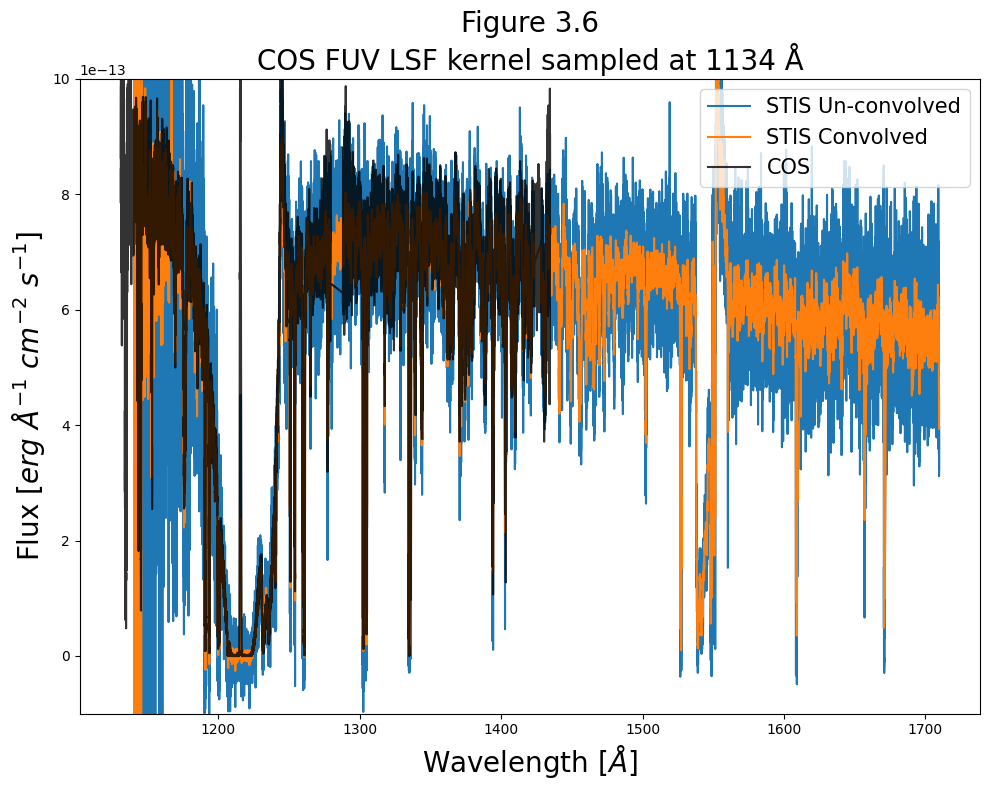

In [32]:
# Set up figure
plt.figure(figsize=(10, 8))

# Plot each of the spectra
plt.plot(STIS_wvln, STIS_flux,
         linestyle='-',
         c='C0',
         label="STIS Un-convolved")

plt.plot(STIS_lwvln, STIS_lflux,
         markersize=1,
         linestyle='-',
         c='C1',
         label="STIS Convolved")

plt.plot(COS_wvln, COS_flux,
         markersize=0.1,
         linestyle='-',
         c='k',
         alpha=0.8,
         label="COS")

# Set ybounds to avoid spike at shorter wvln side
plt.ylim(-1E-13, 1E-12)

# Add a legend
plt.legend(fontsize=15,
           loc='upper right')

# Give fig the title and labels
plt.title("Figure 3.6\nCOS FUV LSF kernel sampled at 1134 Å",
          size=20)
plt.xlabel(r"Wavelength [$\AA$]",
           size=20)
plt.ylabel(r"Flux [$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]",
           size=20)

# Format and save the figure
plt.tight_layout()

plt.savefig(str(plotsdir / 'COS_STIS_compare_wide.png'),
            bbox_inches='tight')

We can tell that the peaks have been cut shorter in the STIS convolved spectrum.

However, to see a bit more detail, let's make plots zooming in on spectral lines. We arbitrarily selected a few spectral lines in the UV from Table 1 of [Leitherer et al.'s "An ultraviolet spectroscopic atlas of local starbursts and star-forming galaxies: the legacy of FOS and GHRS." The Astronomical Journal 141, no. 2 (2011): 37.](https://iopscience.iop.org/article/10.1088/0004-6256/141/2/37/meta)

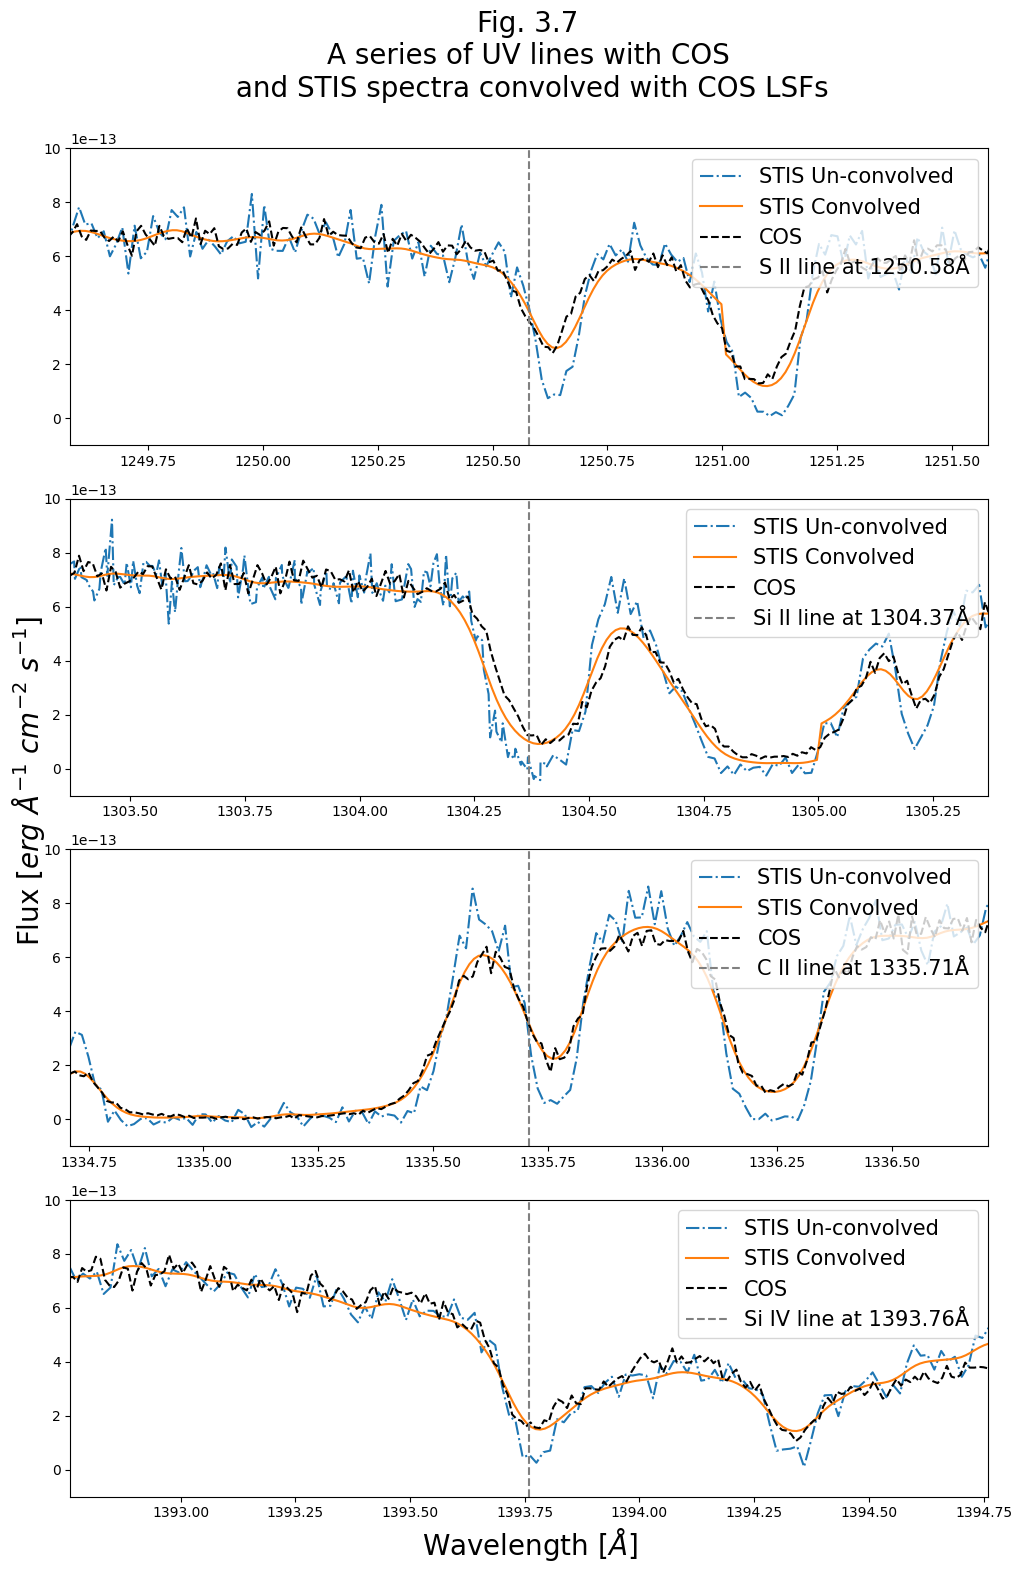

In [33]:
# Select a few UV lines from the table in Leitherer et al, 2011
lines = {"S II": 1250.58, "Si II": 1304.37, "C II": 1335.71, "Si IV": 1393.76}

# Set up figure
fig = plt.figure(figsize=(10, 16))

# Using gridspec to let us control panel sizes and locations
gs = fig.add_gridspec(nrows=4, ncols=1)  

# For each line:
for i, (linename, line) in enumerate(lines.items()):  

    # Add a plot at the correct position on the grid
    ax = fig.add_subplot(gs[i, 0]) 

    # Plot all the spectra for each line
    ax.plot(STIS_wvln, STIS_flux,
            linestyle="-.",
            c="C0",  
            label="STIS Un-convolved")
    
    ax.plot(STIS_lwvln, STIS_lflux,
            markersize=1,
            linestyle="-",
            c="C1",
            label="STIS Convolved")
    
    ax.plot(COS_wvln, COS_flux, 
            markersize=0.1,
            linestyle="--",
            c="k", 
            label="COS")
    
    # Add a vertical line at the reference frame wavelength of the line
    ax.axvline(line,
               c="gray",
               linestyle="--",
               label=f"{linename} line at {line}Å")

    # Set bounds and add legends
    ax.set_xlim(line - 1, line + 1)
    ax.set_ylim(-1e-13, 1e-12)

    ax.legend(fontsize=15,
              loc="upper right")

# Give fig the title and labels
fig.suptitle("Fig. 3.7\nA series of UV lines with COS\n and STIS spectra convolved with COS LSFs\n",
             size=20,)
ax.set_xlabel(r"Wavelength [$\AA$]",
              size=20)
fig.text(s=r"Flux [$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]",
         x=-0.018, y=0.4,
         rotation="vertical",
         size=20)

# Format and save the figure
plt.tight_layout()

plt.savefig(str(plotsdir / "COS_STIS_compare.png"),
            bbox_inches="tight")

#### We'll do something similar again for the NUV:

**First downloading the NUV data to compare.**

Note we're downloading a STIS spectrum from the ULLYSES high level science products archive:

In [34]:
# Downloading ULLYSES STIS data from mast using the URI and saving the local path
Observations.download_file(
    uri="mast:HLSP/ullyses/bi173/dr6/hlsp_ullyses_hst_stis_bi173_e230m_dr6_cspec.fits",
)
stis_nuv_cspec = "./hlsp_ullyses_hst_stis_bi173_e230m_dr6_cspec.fits"

INFO: Found cached file hlsp_ullyses_hst_stis_bi173_e230m_dr6_cspec.fits with expected size 417600. [astroquery.query]


In [35]:
# Now downloading COS
nuv_cos_x1dsum = Observations.download_products(
    Observations.get_product_list(Observations.query_criteria(obs_id="LBY615010")),
    mrp_only=True)[1]["Local Path"]

INFO: Found cached file ./mastDownload/HST/lby615010/lby615010_asn.fits with expected size 11520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lby615010/lby615010_x1dsum.fits with expected size 244800. [astroquery.query]


**Now read in all the COS and STIS data and convolve the STIS data with the COS NUV LSFs:**

In [36]:
# Read in both COS and STIS NUV data:
# COS we need to build up from 3 stripes
cos_nuv_table = Table.read(nuv_cos_x1dsum)

COS_nuv_wvln, COS_nuv_flux = [], []

# The COS segment at index 0 has a longer wvln domain
for cos_segment in [0, 1, 2]:  
    COS_wvln_, COS_flux_ = list(cos_nuv_table[cos_segment]["WAVELENGTH", "FLUX"])
    COS_dqw_ = np.asarray(cos_nuv_table[cos_segment]["DQ_WGT"],
                          dtype=bool)
    
    COS_nuv_wvln += list(COS_wvln_[COS_dqw_])
    COS_nuv_flux += list(COS_flux_[COS_dqw_])
    
COS_nuv_wvln, COS_nuv_flux = np.asarray(COS_nuv_wvln), np.asarray(COS_nuv_flux)

# Read STIS:
STIS_nuv_wvln, STIS_nuv_flux = Table.read(stis_nuv_cspec)["WAVELENGTH", "FLUX"][0]

# Convolve STIS with COS' LSFs:
STIS_nuv_lwvln, STIS_nuv_lflux = convolve_lsf(STIS_nuv_wvln,
                                              STIS_nuv_flux,
                                              1921,
                                              str(datadir / nuv_LSF_file_name),
                                              nuv_disptab_path,
                                              detector="NUV")

Detector used: nuv


**Finally, generate a plot like Fig 3.7, but for this NUV data:**

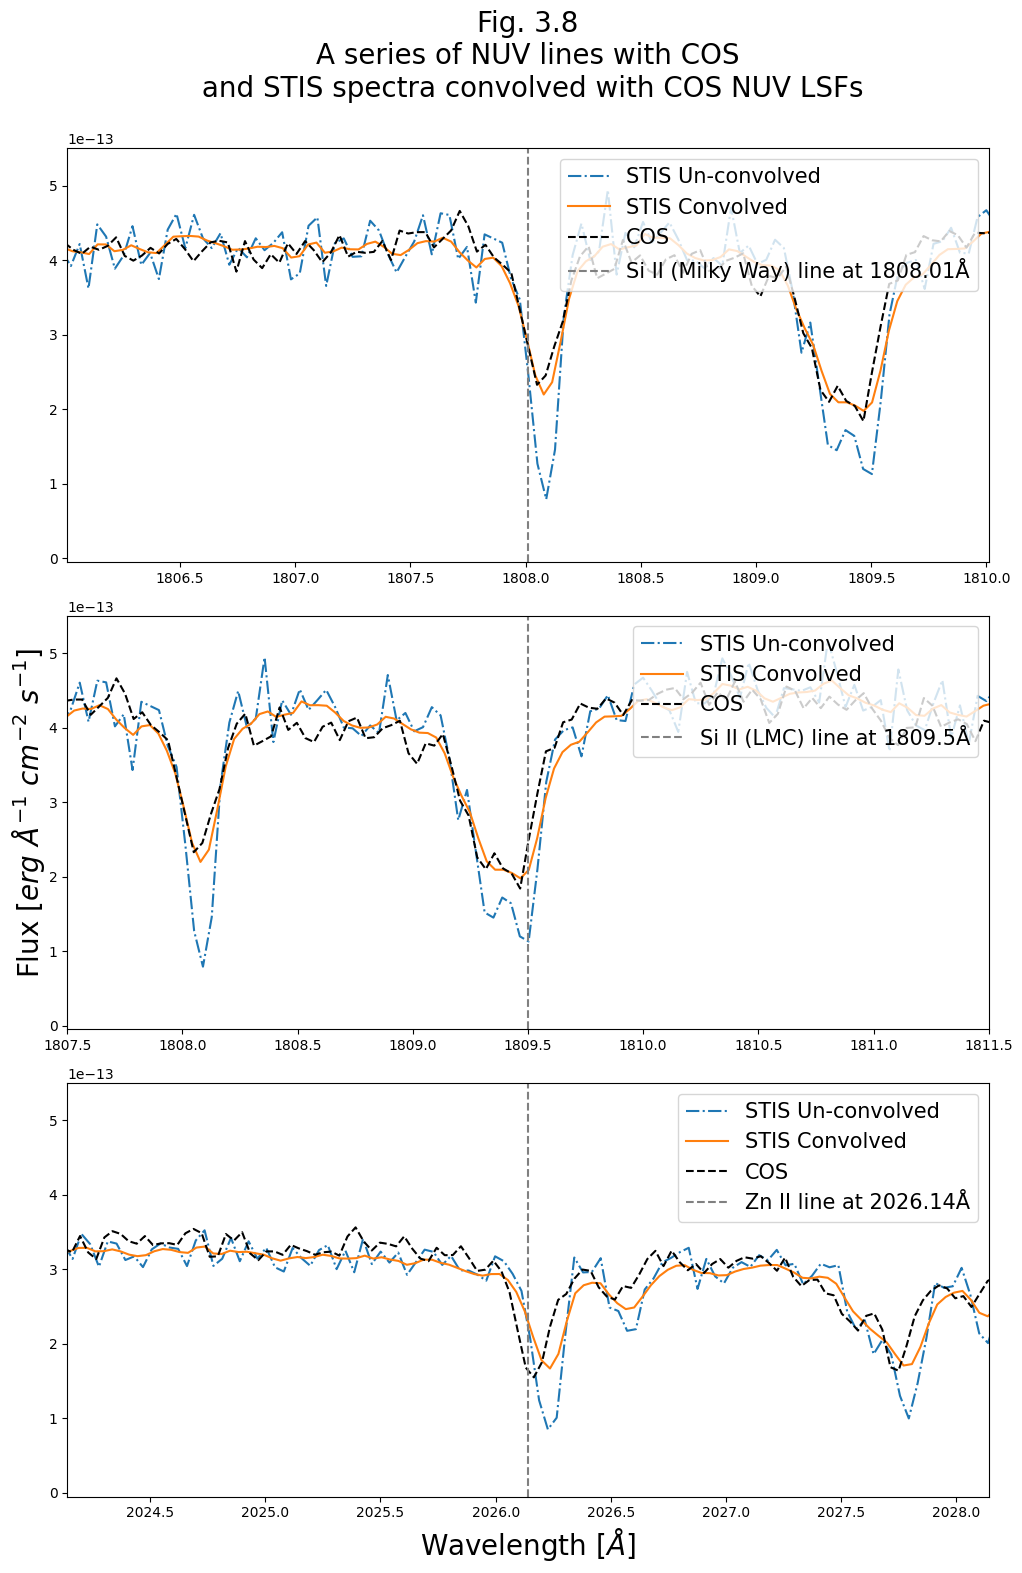

In [37]:
# Select a few NUV lines from the table in Leitherer et al, 2011
lines = {"Si II (Milky Way)": 1808.01, "Si II (LMC)": 1809.5, "Zn II": 2026.14}

# Set up figure
fig = plt.figure(figsize=(10, 16))

# Using gridspec to let us control panel sizes and locations
gs = fig.add_gridspec(nrows=3, ncols=1)  

# For each line:
for i, (linename, line) in enumerate(lines.items()):  
    # Add a plot at the correct position on the grid
    ax = fig.add_subplot(gs[i, 0])  

    # Plot all the spectra for each line
    ax.plot(STIS_nuv_wvln, STIS_nuv_flux,
            linestyle="-.",
            c="C0",  
            label="STIS Un-convolved")
    
    ax.plot(STIS_nuv_lwvln, STIS_nuv_lflux,
            markersize=1,
            linestyle="-",
            c="C1",
            label="STIS Convolved")
    
    ax.plot(COS_nuv_wvln, COS_nuv_flux, 
            markersize=0.1,
            linestyle="--",
            c="k", 
            label="COS")
    
    # Add a vertical line at the reference frame wavelength of the line
    ax.axvline(line,
               c="gray",
               linestyle="--",
               label=f"{linename} line at {line}Å")

    # Set bounds and add legends
    ax.set_xlim(line - 2, line + 2)
    ax.set_ylim(-5e-15, 5.5e-13)

    ax.legend(fontsize=15,
              loc="upper right")

# Give fig the title and labels
fig.suptitle(
    "Fig. 3.8\nA series of NUV lines with COS\n and STIS spectra convolved with COS NUV LSFs\n",
    size=20)
ax.set_xlabel(r"Wavelength [$\AA$]",
              size=20)
fig.text(s=r"Flux [$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]",
         x=-0.018, y=0.38,
         rotation="vertical",
         size=20)

# Format and save the figure
plt.tight_layout()

plt.savefig(str(plotsdir / "COS_STIS_compare_nuv.png"),
            bbox_inches="tight")

## In review:
We've learned...
* What a Line Spread Function (LSF) is and why we might need to use it
* How to determine the correct LSF for your COS data and find it on the [COS Spectral Resolution Website](https://www.stsci.edu/hst/instrumentation/cos/performance/spectral-resolution)
* How to convolve LSFs with a template spectrum

## Congratulations! You finished this Notebook!
<font size="5">There are more COS data walkthrough Notebooks on different topics. You can find them <a href="https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/COS">here</a>.</font>


---
## About this Notebook
**Author:** Nat Kerman 

**Curator:** Anna Payne apayne@stsci.edu

**Contributors:** Rachel Plesha, Julia Roman-Duval

**Updated On:** 2023-06-29

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `matplotlib`](https://matplotlib.org/)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

<hr>

[Top of Page](#topL)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>